In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, RidgeCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFE, SelectKBest, chi2, f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [154]:
# Cargo el dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", 
                "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", 
                "hours_per_week", "native_country", "income"]
data = pd.read_csv(url, names=column_names)

In [155]:
# Convierto las columnas categóricas a tipo 'category'
categorical_columns = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country', 'income']
for column in categorical_columns:
    data[column] = data[column].astype('category')

In [156]:
# Convertir 'income' a binario
data['income_binary'] = data['income'].cat.codes

In [157]:
#Mostramos la información o contenido del dataset
print(data.head())  # Ver las primeras filas del dataset
print(data.info())  # Resumen de los tipos de datos y valores nulos
print(data.describe())  # Estadísticas básicas de las variables numéricas

   age          workclass  fnlwgt   education  education_num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital_status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital_gain  capital_loss  hours_per_week  native_country  income  \
0          2174             0              40   United-States   <=5

In [158]:
# Identifico valores perdidos 
missing_values = data.isnull().sum() # Contar valores nulos por columna
print(missing_values)



age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
income_binary     0
dtype: int64


In [159]:
# Verificar valores únicos en cada columna categórica
for col in categorical_columns:
    print(f"{col}: {data[col].nunique()} valores únicos")

# Ver los valores únicos con sus respectivas frecuencias
for col in categorical_columns:
    print(f"\nValores únicos en {col}:")
    print(data[col].value_counts())

workclass: 9 valores únicos
education: 16 valores únicos
marital_status: 7 valores únicos
occupation: 15 valores únicos
relationship: 6 valores únicos
race: 5 valores únicos
sex: 2 valores únicos
native_country: 42 valores únicos
income: 2 valores únicos

Valores únicos en workclass:
workclass
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64

Valores únicos en education:
education
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: count, dtype: int64

Valores únicos en marital_

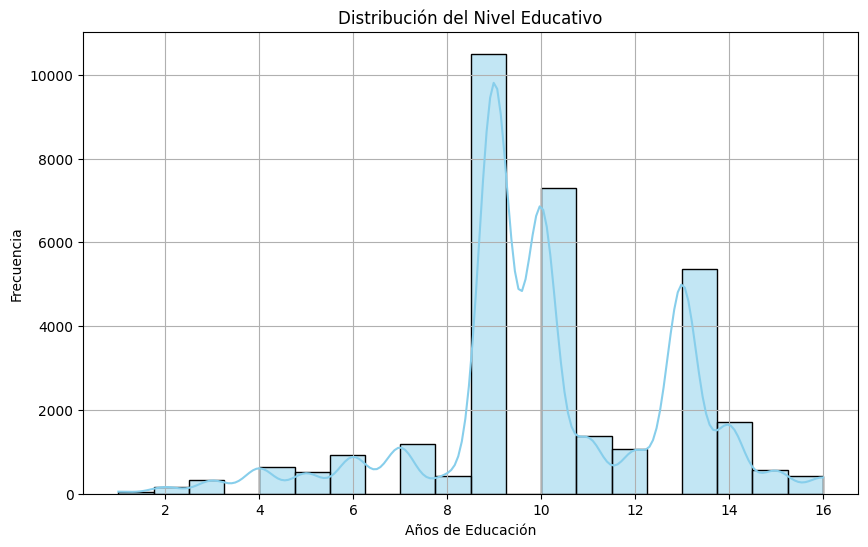

In [160]:
# # Histograma del Nivel Educativo (Matplotlib)

plt.figure(figsize=(10, 6))
sns.histplot(data['education_num'], kde=True, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribución del Nivel Educativo')
plt.xlabel('Años de Educación')
plt.ylabel('Frecuencia')
plt.grid(True) 
plt.show()

In [161]:
# Resumen numérico
print("Resumen del Nivel Educativo:")
print(data['education_num'].describe())

Resumen del Nivel Educativo:
count    32561.000000
mean        10.080679
std          2.572720
min          1.000000
25%          9.000000
50%         10.000000
75%         12.000000
max         16.000000
Name: education_num, dtype: float64


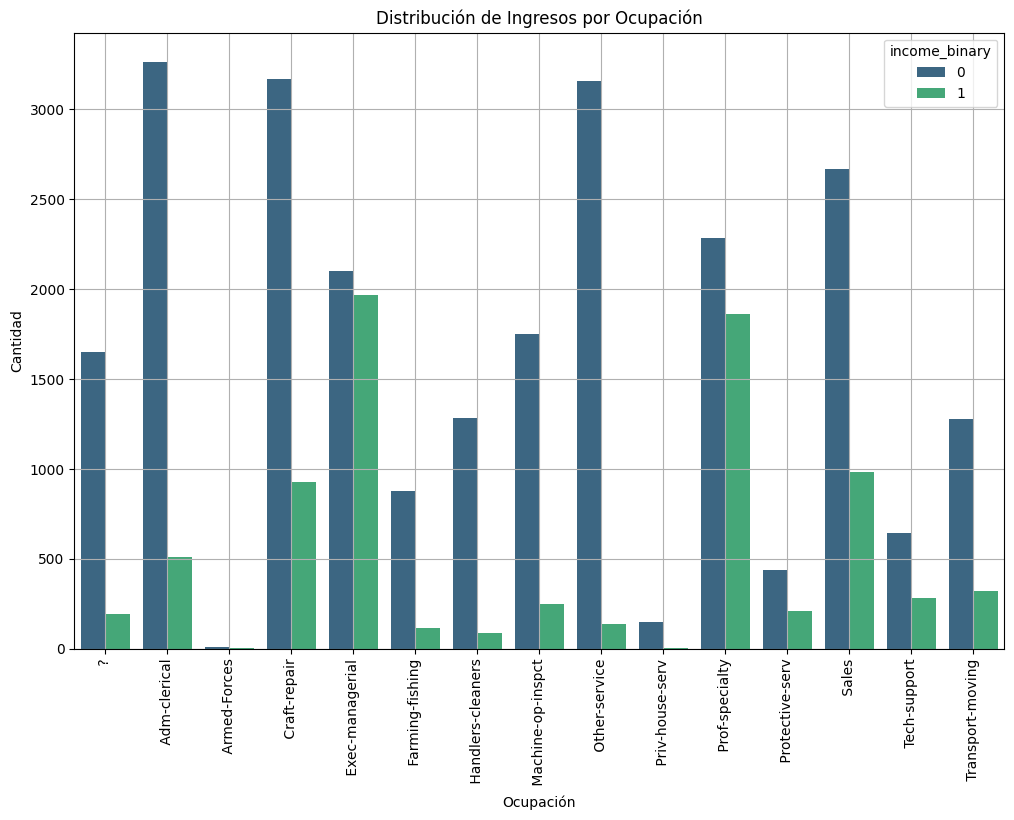

In [162]:
# # Gráfico de Barras de Ingresos por Ocupación (Seaborn)

plt.figure(figsize=(12, 8))
sns.countplot(x='occupation', hue='income_binary', data=data, palette='viridis')
plt.title('Distribución de Ingresos por Ocupación')
plt.xlabel('Ocupación')
plt.ylabel('Cantidad')
plt.xticks(rotation=90)  
plt.grid(True)
plt.show()

In [163]:
# Resumen numérico de Ingresos por Ocupación
print("Resumen de Ingresos por Ocupación:")
income_summary = data.groupby('occupation')['income_binary'].describe()
print(income_summary)

Resumen de Ingresos por Ocupación:
                    count      mean       std  min  25%  50%  75%  max
occupation                                                            
?                  1843.0  0.103635  0.304870  0.0  0.0  0.0  0.0  1.0
Adm-clerical       3770.0  0.134483  0.341216  0.0  0.0  0.0  0.0  1.0
Armed-Forces          9.0  0.111111  0.333333  0.0  0.0  0.0  0.0  1.0
Craft-repair       4099.0  0.226641  0.418709  0.0  0.0  0.0  0.0  1.0
Exec-managerial    4066.0  0.484014  0.499806  0.0  0.0  0.0  1.0  1.0
Farming-fishing     994.0  0.115694  0.320019  0.0  0.0  0.0  0.0  1.0
Handlers-cleaners  1370.0  0.062774  0.242644  0.0  0.0  0.0  0.0  1.0
Machine-op-inspct  2002.0  0.124875  0.330660  0.0  0.0  0.0  0.0  1.0
Other-service      3295.0  0.041578  0.199653  0.0  0.0  0.0  0.0  1.0
Priv-house-serv     149.0  0.006711  0.081923  0.0  0.0  0.0  0.0  1.0
Prof-specialty     4140.0  0.449034  0.497456  0.0  0.0  0.0  1.0  1.0
Protective-serv     649.0  0.325116  0.468

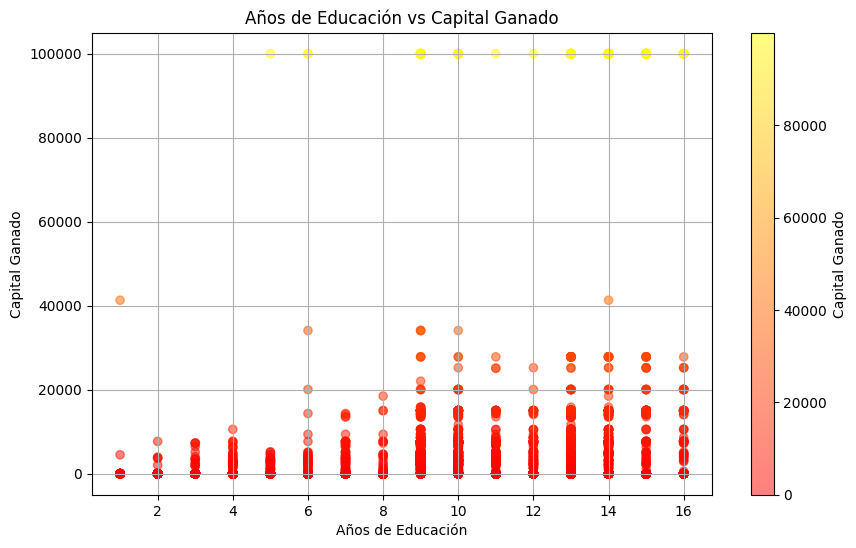

In [164]:
# # Scatterplot: Años de Educación vs Capital Ganado (Matplotlib)
plt.figure(figsize=(10, 6))
plt.scatter(data['education_num'], data['capital_gain'], alpha=0.5, c=data['capital_gain'], cmap='autumn')
plt.title('Años de Educación vs Capital Ganado')
plt.xlabel('Años de Educación')
plt.ylabel('Capital Ganado')
plt.colorbar(label='Capital Ganado') 
plt.grid(True)
plt.show()

In [165]:
# Resumen numérico de Años de Educación y Capital Ganado
print("Resumen de Años de Educación y Capital Ganado:")
education_capital_summary = data[['education_num', 'capital_gain']].describe()
print(education_capital_summary)

# Correlación entre Años de Educación y Capital Ganado
correlation = data['education_num'].corr(data['capital_gain'])
print(f"\nCorrelación entre Años de Educación y Capital Ganado: {correlation:.2f}")

Resumen de Años de Educación y Capital Ganado:
       education_num  capital_gain
count   32561.000000  32561.000000
mean       10.080679   1077.648844
std         2.572720   7385.292085
min         1.000000      0.000000
25%         9.000000      0.000000
50%        10.000000      0.000000
75%        12.000000      0.000000
max        16.000000  99999.000000

Correlación entre Años de Educación y Capital Ganado: 0.12


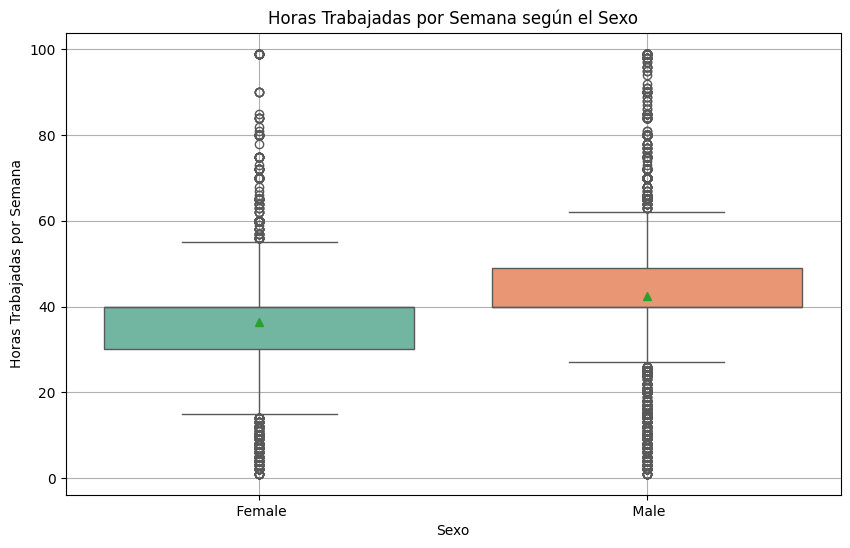

In [166]:
# # Boxplot de Horas Trabajadas por Semana según el Sexo (Seaborn)

plt.figure(figsize=(10, 6))
sns.boxplot(x='sex', y='hours_per_week', data=data, palette='Set2', showmeans=True)
plt.title('Horas Trabajadas por Semana según el Sexo')
plt.xlabel('Sexo')
plt.ylabel('Horas Trabajadas por Semana')
plt.grid(True)
plt.show()

In [167]:
# Resumen numérico
print("Resumen de Horas Trabajadas por Semana según el Sexo:")
print(data.groupby('sex')['hours_per_week'].describe())

Resumen de Horas Trabajadas por Semana según el Sexo:
          count       mean        std  min   25%   50%   75%   max
sex                                                               
Female  10771.0  36.410361  11.811300  1.0  30.0  40.0  40.0  99.0
Male    21790.0  42.428086  12.119755  1.0  40.0  40.0  49.0  99.0


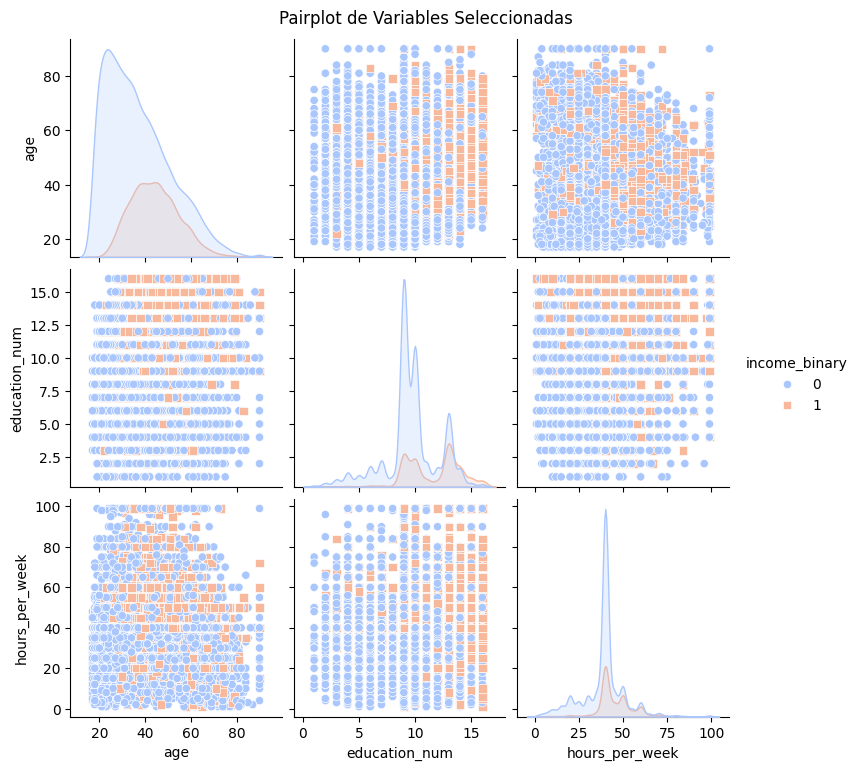

In [168]:
# # Pairplot de Variables Seleccionadas (Seaborn)

sns.pairplot(data[['age', 'education_num', 'hours_per_week', 'income_binary']], hue='income_binary', palette='coolwarm', markers=["o", "s"])
plt.suptitle('Pairplot de Variables Seleccionadas', y=1.02)
plt.show()

In [94]:
# Resumen numérico
print("Resumen de Variables Seleccionadas:")
print(data[['age', 'education_num', 'hours_per_week', 'income_binary']].describe())



Resumen de Variables Seleccionadas:
                age  education_num  hours_per_week  income_binary
count  32561.000000   32561.000000    32561.000000   32561.000000
mean      38.581647      10.080679       40.437456       0.240810
std       13.640433       2.572720       12.347429       0.427581
min       17.000000       1.000000        1.000000       0.000000
25%       28.000000       9.000000       40.000000       0.000000
50%       37.000000      10.000000       40.000000       0.000000
75%       48.000000      12.000000       45.000000       0.000000
max       90.000000      16.000000       99.000000       1.000000


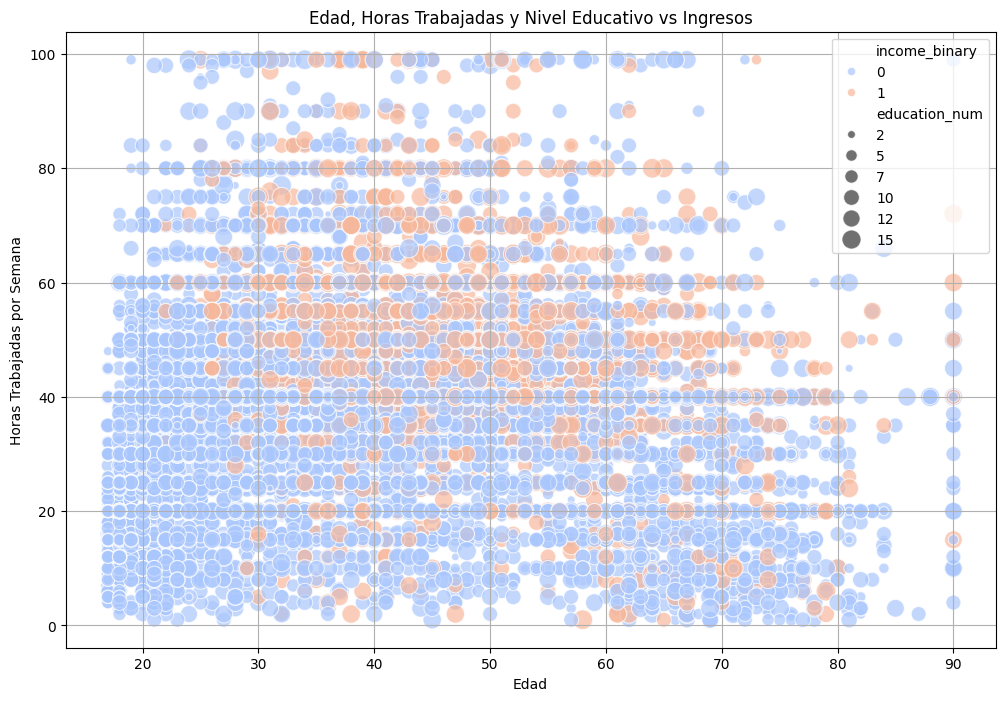

In [95]:
# # Gráfico de Dispersión Multivariado (Seaborn)

plt.figure(figsize=(12, 8))
sns.scatterplot(x='age', y='hours_per_week', size='education_num', hue='income_binary', data=data, sizes=(20, 200), palette='coolwarm', alpha=0.7)
plt.title('Edad, Horas Trabajadas y Nivel Educativo vs Ingresos')
plt.xlabel('Edad')
plt.ylabel('Horas Trabajadas por Semana')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [96]:
# Resumen numérico
print("Resumen de Edad, Horas Trabajadas y Nivel Educativo:")
print(data[['age', 'hours_per_week', 'education_num', 'income_binary']].describe())

Resumen de Edad, Horas Trabajadas y Nivel Educativo:
                age  hours_per_week  education_num  income_binary
count  32561.000000    32561.000000   32561.000000   32561.000000
mean      38.581647       40.437456      10.080679       0.240810
std       13.640433       12.347429       2.572720       0.427581
min       17.000000        1.000000       1.000000       0.000000
25%       28.000000       40.000000       9.000000       0.000000
50%       37.000000       40.000000      10.000000       0.000000
75%       48.000000       45.000000      12.000000       0.000000
max       90.000000       99.000000      16.000000       1.000000


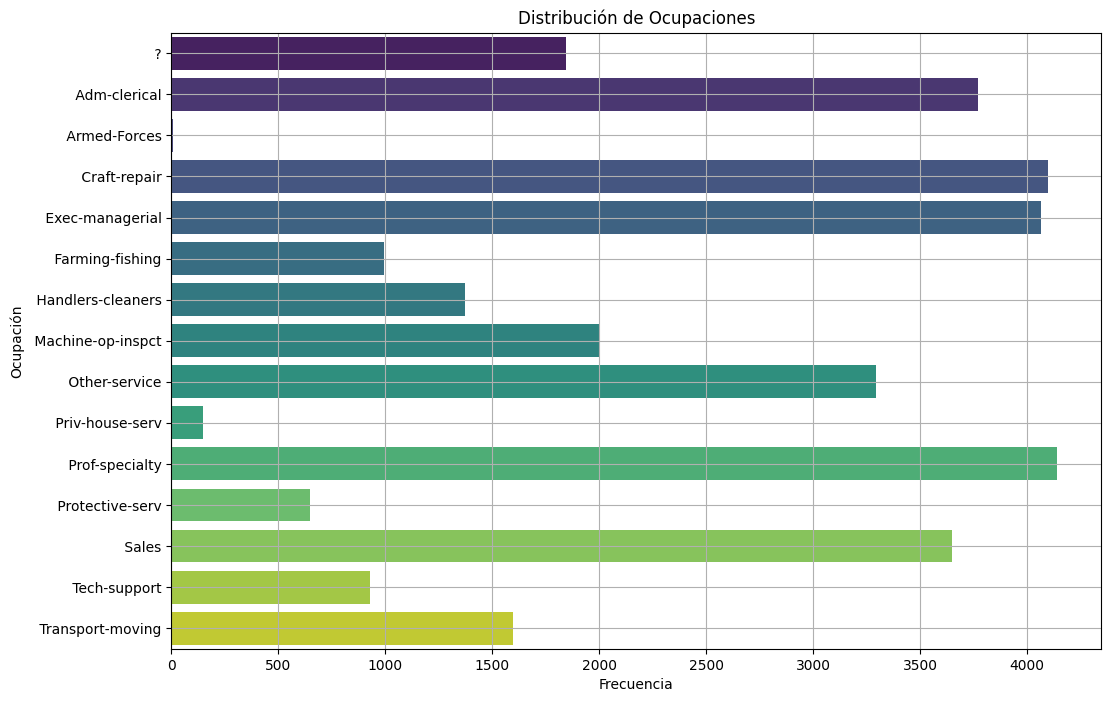

In [97]:
# # Countplot de ocupación (Seaborn)
plt.figure(figsize=(12, 8))
sns.countplot(y='occupation', data=data, hue='occupation', palette='viridis', dodge=False)
plt.title('Distribución de Ocupaciones')
plt.xlabel('Frecuencia')
plt.ylabel('Ocupación')
plt.grid(True)
plt.legend([],[], frameon=False) 
plt.show()

In [98]:
# Resumen numérico
occupation_counts = data['occupation'].value_counts()
print("Resumen de la Distribución de Ocupaciones:")
print(occupation_counts)
print("\nResumen Estadístico:")
print(data['occupation'].describe())

Resumen de la Distribución de Ocupaciones:
occupation
Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: count, dtype: int64

Resumen Estadístico:
count               32561
unique                 15
top        Prof-specialty
freq                 4140
Name: occupation, dtype: object


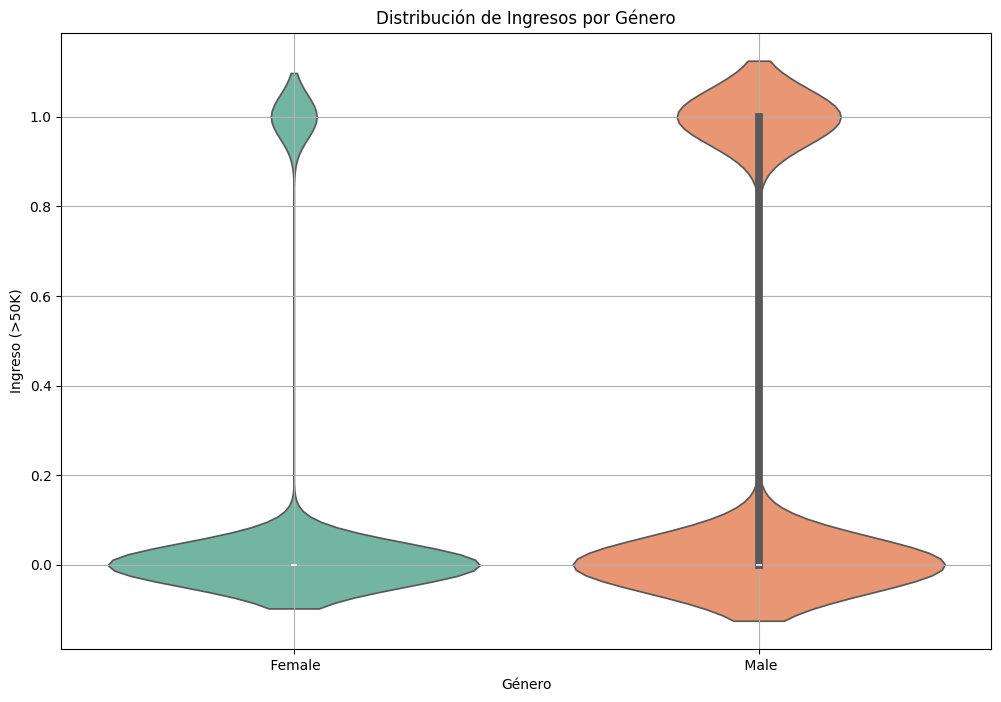

Resumen de Ingresos por Género:
          count      mean       std  min  25%  50%  75%  max
sex                                                         
Female  10771.0  0.109461  0.312231  0.0  0.0  0.0  0.0  1.0
Male    21790.0  0.305737  0.460729  0.0  0.0  0.0  1.0  1.0


In [169]:
# # Gráfico de Violín: Ingresos por Género (Seaborn)

plt.figure(figsize=(12, 8))
sns.violinplot(x='sex', y='income_binary', data=data, palette='Set2')
plt.title('Distribución de Ingresos por Género')
plt.xlabel('Género')
plt.ylabel('Ingreso (>50K)')
plt.grid(True)
plt.show()

# Resumen numérico de Ingresos por Género
income_by_sex = data.groupby('sex')['income_binary'].describe()
print("Resumen de Ingresos por Género:")
print(income_by_sex)

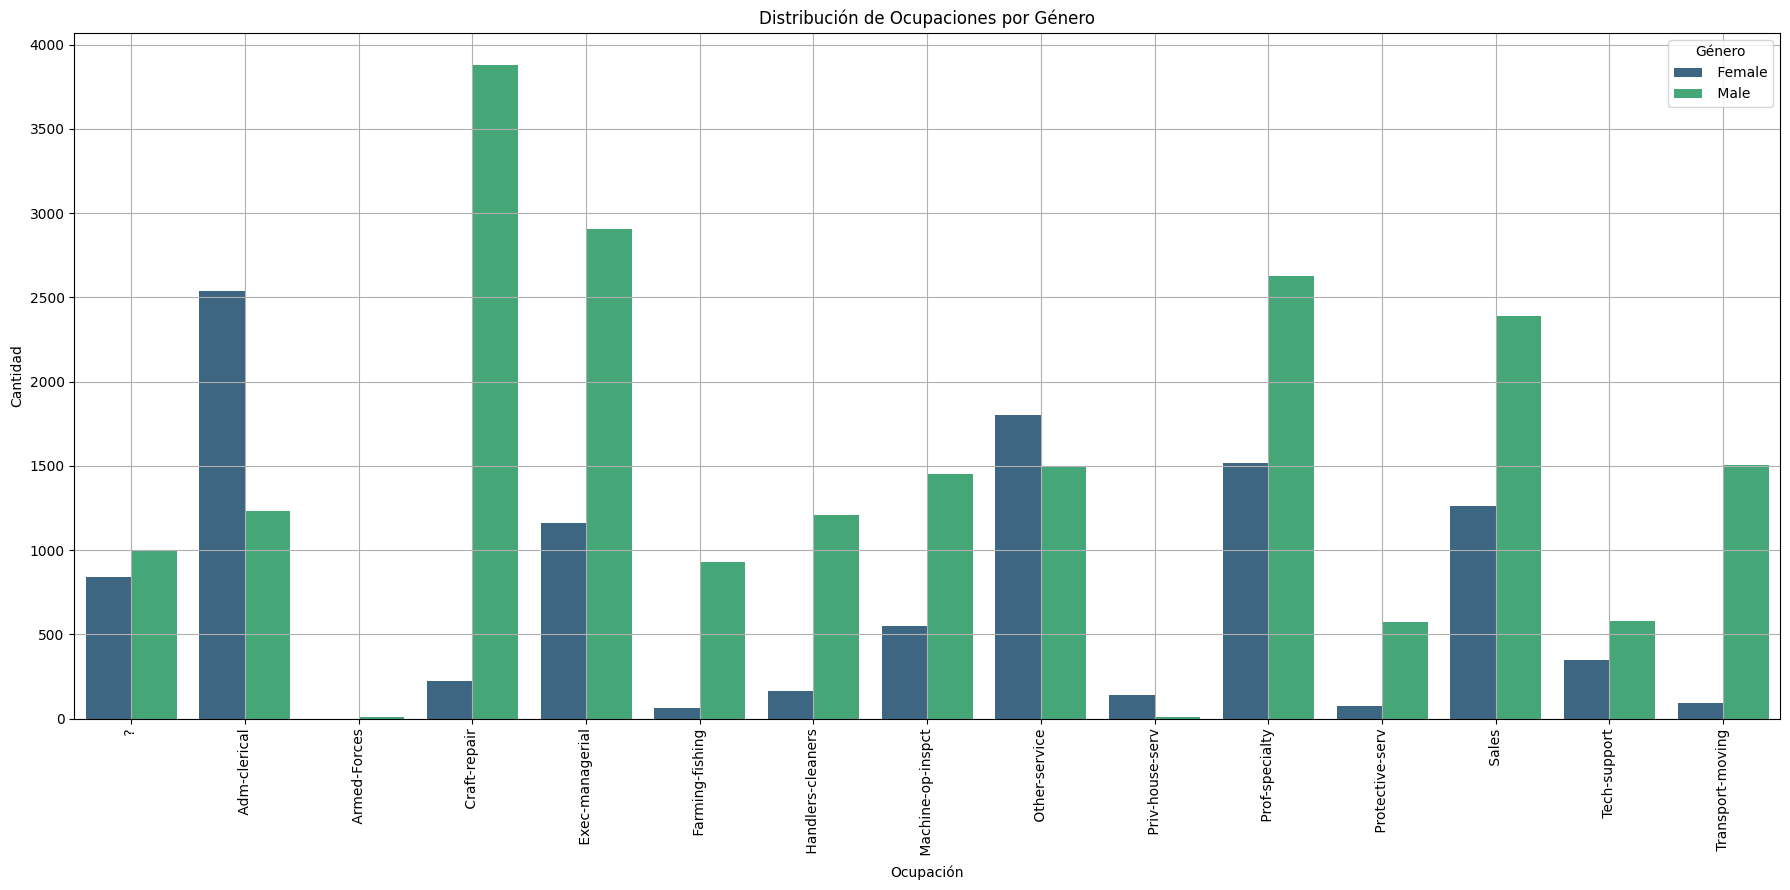

In [100]:
# # Gráfico de Barras Agrupadas: Ocupaciones por Género
plt.figure(figsize=(18, 9))
sns.countplot(x='occupation', hue='sex', data=data, palette='viridis')
plt.title('Distribución de Ocupaciones por Género')
plt.xlabel('Ocupación')
plt.ylabel('Cantidad')
plt.xticks(rotation=90)
plt.legend(title='Género')
plt.grid(True)
plt.tight_layout() 
plt.show()

In [170]:
# Resumen numérico por ocupación y género
occupation_gender_counts = data.groupby(['occupation', 'sex']).size().unstack(fill_value=0).describe()

print("Resumen de Ocupaciones por Género:")
print(occupation_gender_counts)

# Resumen numérico de la cantidad de personas por ocupación y género
occupation_gender_counts = data.groupby(['occupation', 'sex']).size().unstack(fill_value=0)
print("Cantidad de Personas por Ocupación y Género:")
print(occupation_gender_counts)

Resumen de Ocupaciones por Género:
sex         Female         Male
count    15.000000    15.000000
mean    718.066667  1452.666667
std     775.554867  1086.856126
min       0.000000     8.000000
25%     115.500000   754.500000
50%     348.000000  1233.000000
75%    1211.000000  1947.000000
max    2537.000000  3877.000000
Cantidad de Personas por Ocupación y Género:
sex                Female  Male
occupation                     
?                     841  1002
Adm-clerical         2537  1233
Armed-Forces            0     9
Craft-repair          222  3877
Exec-managerial      1159  2907
Farming-fishing        65   929
Handlers-cleaners     164  1206
Machine-op-inspct     550  1452
Other-service        1800  1495
Priv-house-serv       141     8
Prof-specialty       1515  2625
Protective-serv        76   573
Sales                1263  2387
Tech-support          348   580
Transport-moving       90  1507


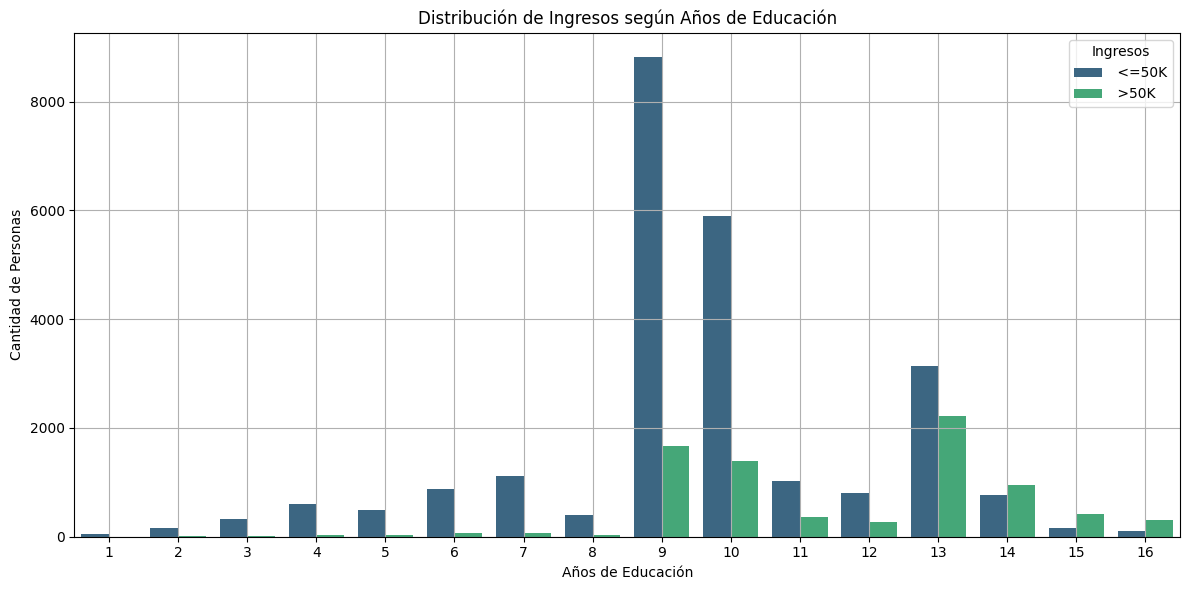

Resumen numérico: Porcentaje de Ingresos >50K según Años de Educación
income_binary       <=50K       >50K
education_num                       
1              100.000000   0.000000
2               96.428571   3.571429
3               95.195195   4.804805
4               93.808050   6.191950
5               94.747082   5.252918
6               93.354770   6.645230
7               94.893617   5.106383
8               92.378753   7.621247
9               84.049138  15.950862
10              80.976546  19.023454
11              73.878437  26.121563
12              75.164011  24.835989
13              58.524743  41.475257
14              44.341265  55.658735
15              26.562500  73.437500
16              25.907990  74.092010


In [102]:
# Convertir la columna de ingresos a binaria: 1 si >50K, 0 si <=50K
data['income_binary'] = data['income'].apply(lambda x: ' >50K' if x == ' >50K' else ' <=50K')

# Gráfico de Barras Agrupadas: Distribución de Ingresos según Años de Educación
plt.figure(figsize=(12, 6))
sns.countplot(x='education_num', hue='income_binary', data=data, palette='viridis')
plt.title('Distribución de Ingresos según Años de Educación')
plt.xlabel('Años de Educación')
plt.ylabel('Cantidad de Personas')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Ingresos')
plt.show()

# Resumen numérico: Porcentaje de Ingresos >50K según Años de Educación
education_income_percentage = data.groupby('education_num')['income_binary'].value_counts(normalize=True).unstack() * 100

# Mostrar el resumen numérico
print("Resumen numérico: Porcentaje de Ingresos >50K según Años de Educación")
print(education_income_percentage)

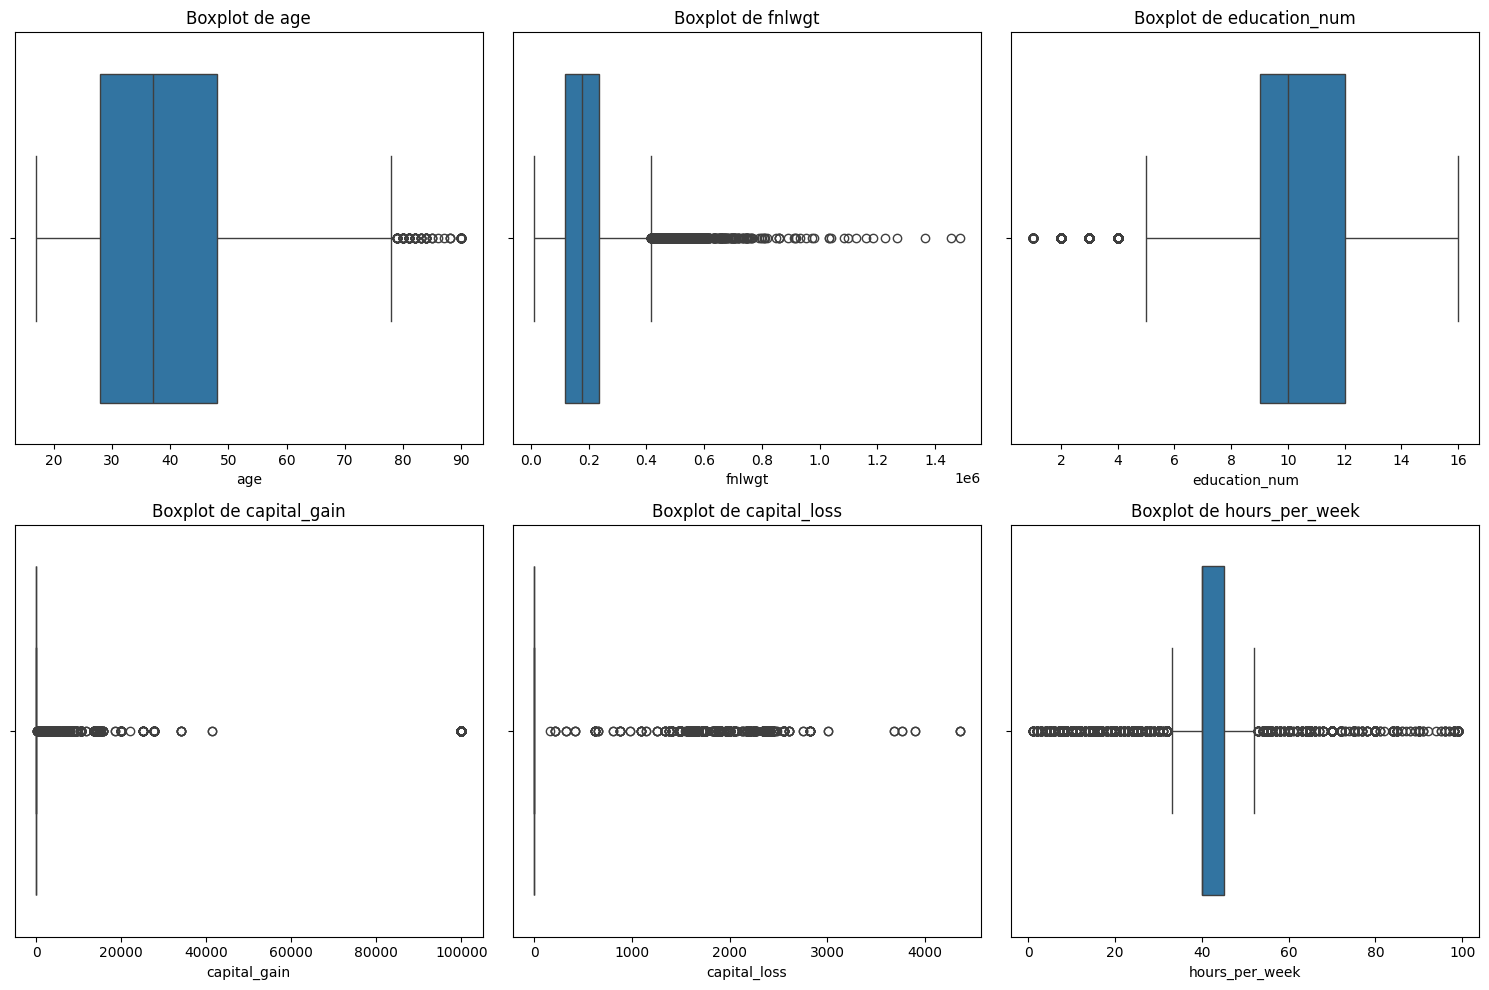

Número de outliers detectados en cada variable:
{'age': 143, 'fnlwgt': 992, 'education_num': 1198, 'capital_gain': 2712, 'capital_loss': 1519, 'hours_per_week': 9008}


In [103]:
## Busco outliers

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", 
                "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", 
                "hours_per_week", "native_country", "income"]

# Lista de variables numéricas para analizar outliers
numerical_features = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

# Crear un gráfico de boxplots para cada variable numérica
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=data[feature])
    plt.title(f'Boxplot de {feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()

# Función para detectar outliers usando el rango intercuartil (IQR)
def detect_outliers_iqr(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Identificar outliers para cada variable numérica
outliers = {}
for feature in numerical_features:
    lower_bound, upper_bound = detect_outliers_iqr(data, feature)
    outliers[feature] = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)].shape[0]

print("Número de outliers detectados en cada variable:")
print(outliers)



In [104]:
# Resumen estadístico de las variables numéricas
summary_stats = data.describe()

# Identificación de outliers usando el método del rango intercuartil (IQR)
def identify_outliers(df, columns):
    outliers = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    return outliers

# Variables numéricas para el análisis de outliers
numeric_columns = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

# Resumen estadístico
print("Resumen estadístico de las variables numéricas:\n")
print(summary_stats)

# Identificación de outliers
outliers = identify_outliers(data, numeric_columns)

print("\nNúmero de outliers detectados en cada variable:")
for col, count in outliers.items():
    print(f'{col}: {count}')


Resumen estadístico de las variables numéricas:

                age        fnlwgt  education_num  capital_gain  capital_loss  \
count  32561.000000  3.256100e+04   32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05      10.080679   1077.648844     87.303830   
std       13.640433  1.055500e+05       2.572720   7385.292085    402.960219   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370510e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours_per_week  
count    32561.000000  
mean        40.437456  
std         12.347429  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  

Número de out

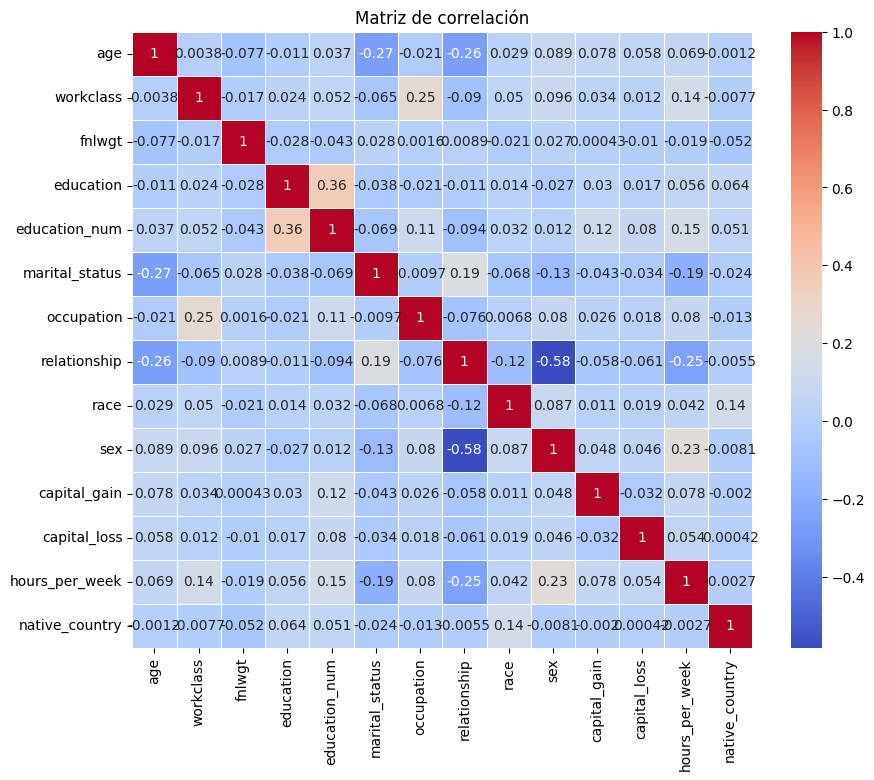

P-values de Chi-cuadrado:
[0.00000000e+000 5.47766026e-012 0.00000000e+000 9.24882165e-067
 0.00000000e+000 2.61759457e-246 9.68421957e-112 0.00000000e+000
 9.06868555e-009 2.80029903e-111 0.00000000e+000 0.00000000e+000
 0.00000000e+000 2.23877386e-004]


In [105]:
# Correlación para variables numéricas y selección Chi-cuadrado para variables categóricas

# Preprocesamiento del dataset

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", 
                "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", 
                "hours_per_week", "native_country", "income"]

# Cargar el dataset, manejar valores faltantes y eliminar espacios iniciales en columnas
df = pd.read_csv(url, names=column_names, na_values=" ?", skipinitialspace=True)

# Eliminar filas con valores faltantes
df = df.dropna()

# Eliminar espacios en la columna 'income' antes de la conversión binaria
df['income'] = df['income'].str.strip()

# Convertir la columna 'income' a binaria (<=50K -> 0, >50K -> 1)
df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

# Codificar variables categóricas usando LabelEncoder
label_encoder = LabelEncoder()
for column in df.select_dtypes(include=['object']).columns:
    df[column] = label_encoder.fit_transform(df[column])

# Separar variables predictoras (X) y la variable objetivo (y)
X = df.drop("income", axis=1)
y = df["income"]

# # Métodos de Filtro

# Correlación para variables numéricas
correlation = X.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de correlación")
plt.show()

# Selección Chi-cuadrado para variables categóricas
X_categorical = X.select_dtypes(include=['int', 'object']) 
chi_selector = SelectKBest(chi2, k='all')
X_kbest = chi_selector.fit_transform(X_categorical, y)

print("P-values de Chi-cuadrado:")
print(chi_selector.pvalues_)

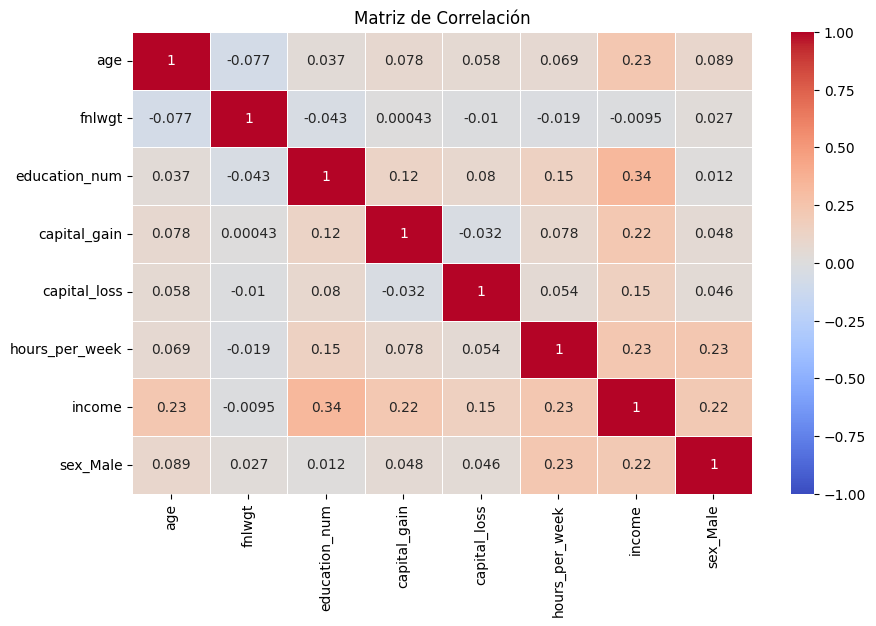

In [145]:
# # matriz de correlación incluyendo income

# Cargar el dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", 
                "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", 
                "hours_per_week", "native_country", "income"]
data = pd.read_csv(url, names=column_names, na_values=" ?", skipinitialspace=True)

# Eliminar filas con valores faltantes
data.dropna(inplace=True)

# Convertir la columna 'income' en una variable binaria (0 y 1)
data['income'] = data['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

# Convertir la columna 'sex' en una variable binaria (0 y 1)
data['sex_Male'] = (data['sex'] == 'Male').astype(int)

# Seleccionar solo variables numéricas para la correlación
numeric_columns = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week', 'income', 'sex_Male']

# Crear la matriz de correlación
corr_matrix = data[numeric_columns].corr()

# Graficar el mapa de calor de la matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()


In [107]:
# # Métodos de Envoltura (RFE)

# División del dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Utilizar RFE con un modelo base de Regresión Logística
logreg = LogisticRegression(max_iter=5000, solver='saga')
rfe = RFE(logreg, n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

# Variables seleccionadas por RFE
print("Variables seleccionadas por RFE:")
selected_features_rfe = X.columns[rfe.support_]
print(selected_features_rfe)

# Evaluación del modelo con las variables seleccionadas
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

logreg.fit(X_train_rfe, y_train)
y_pred_rfe = logreg.predict(X_test_rfe)
accuracy_rfe = accuracy_score(y_test, y_pred_rfe)
print(f"Accuracy con las variables seleccionadas por RFE: {accuracy_rfe}")

Variables seleccionadas por RFE:
Index(['age', 'workclass', 'education', 'education_num', 'marital_status',
       'relationship', 'race', 'capital_loss', 'hours_per_week',
       'native_country'],
      dtype='object')
Accuracy con las variables seleccionadas por RFE: 0.7800184256321016


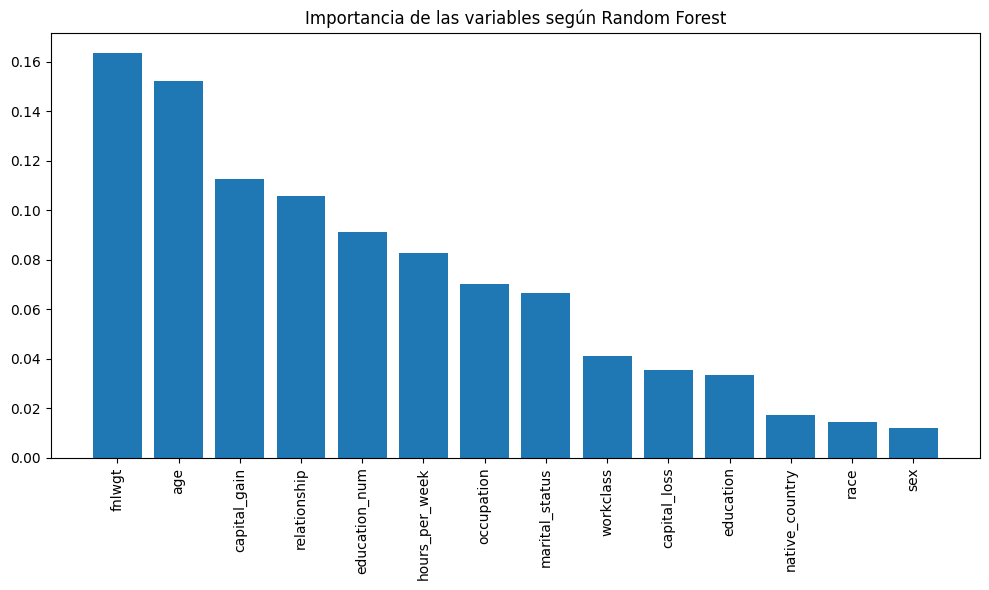

Importancia de las variables según Random Forest:
1. fnlwgt (0.16360087108190746)
2. age (0.1523174027163498)
3. capital_gain (0.11279323422288322)
4. relationship (0.10600503707860547)
5. education_num (0.09114685880973022)
6. hours_per_week (0.08296571539678127)
7. occupation (0.07010882153228107)
8. marital_status (0.06678225939356039)
9. workclass (0.041198546610873264)
10. capital_loss (0.03552850342127385)
11. education (0.033635293549751984)
12. native_country (0.017326665495058825)
13. race (0.014448006435482767)
14. sex (0.012142784255460502)


In [111]:
# Entrenamiento de un modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Importancia de las variables según Random Forest
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Visualización de la importancia de las variables
plt.figure(figsize=(10, 6))
plt.title("Importancia de las variables según Random Forest")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

print("Importancia de las variables según Random Forest:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. {X.columns[indices[f]]} ({importances[indices[f]]})")

In [109]:
# Codifico la variable objetivo (income)
y = df['income']

# Aplicar ANOVA
X = df.drop(columns=['income'])
f_values, p_values = f_classif(X, y)

# Crear un DataFrame para mostrar los resultados
anova_results = pd.DataFrame({'Feature': X.columns, 'F-value': f_values, 'p-value': p_values})
print(anova_results.sort_values(by='p-value'))


           Feature      F-value        p-value
0              age  1886.707314   0.000000e+00
4    education_num  4120.095780   0.000000e+00
7     relationship  2187.645828   0.000000e+00
9              sex  1593.107907   0.000000e+00
10    capital_gain  1709.150064   0.000000e+00
12  hours_per_week  1813.386282   0.000000e+00
5   marital_status  1346.851776  5.860411e-289
11    capital_loss   754.830452  2.686547e-164
3        education   206.129509   1.332889e-46
6       occupation   186.500322   2.415770e-42
8             race   168.934788   1.576828e-38
1        workclass    86.936161   1.189234e-20
13  native_country     8.171557   4.257937e-03
2           fnlwgt     2.915594   8.773666e-02


In [110]:
# # Modelo con y sin 'fnlwgt'
# Separar variables predictoras (X) y la variable objetivo (y)
X = df.drop("income", axis=1)
y = df["income"]

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir de nuevo a DataFrame y crear una nueva variable para el DataFrame escalado
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

# Modelo sin 'fnlwgt'
X_train_no_fnlwgt = X_train_scaled.drop('fnlwgt', axis=1)
X_test_no_fnlwgt = X_test_scaled.drop('fnlwgt', axis=1)

# Inicializar el modelo
model = LogisticRegression(max_iter=5000)

# Validación cruzada para el modelo con 'fnlwgt'
scores_with_fnlwgt = cross_val_score(model, X_train_scaled, y_train, cv=5)
print("Scores con 'fnlwgt':", scores_with_fnlwgt)
print("Precisión promedio con 'fnlwgt':", scores_with_fnlwgt.mean())

# Validación cruzada para el modelo sin 'fnlwgt'
scores_without_fnlwgt = cross_val_score(model, X_train_no_fnlwgt, y_train, cv=5)
print("Scores sin 'fnlwgt':", scores_without_fnlwgt)
print("Precisión promedio sin 'fnlwgt':", scores_without_fnlwgt.mean())



Scores con 'fnlwgt': [0.82627769 0.82408423 0.82382624 0.81636683 0.83106626]
Precisión promedio con 'fnlwgt': 0.8243242491478071
Scores sin 'fnlwgt': [0.82649704 0.825839   0.82250987 0.81702501 0.83150505]
Precisión promedio sin 'fnlwgt': 0.8246751936797454


In [112]:
# Separar variables predictoras (X) y la variable objetivo (y)
X = df.drop("income", axis=1)
y = df["income"]

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modelo con 'fnlwgt'
model_rf_with_fnlwgt = RandomForestClassifier(random_state=42)
model_rf_with_fnlwgt.fit(X_train, y_train)
y_pred_with_fnlwgt = model_rf_with_fnlwgt.predict(X_test)

# Modelo sin 'fnlwgt'
X_train_no_fnlwgt = X_train.drop('fnlwgt', axis=1)
X_test_no_fnlwgt = X_test.drop('fnlwgt', axis=1)

model_rf_without_fnlwgt = RandomForestClassifier(random_state=42)
model_rf_without_fnlwgt.fit(X_train_no_fnlwgt, y_train)
y_pred_without_fnlwgt = model_rf_without_fnlwgt.predict(X_test_no_fnlwgt)

# Comparar los resultados
print("Resultados con 'fnlwgt':")
print(classification_report(y_test, y_pred_with_fnlwgt))

print("Resultados sin 'fnlwgt':")
print(classification_report(y_test, y_pred_without_fnlwgt))

# Validación cruzada para comparar precisión
scores_with_fnlwgt = cross_val_score(model_rf_with_fnlwgt, X_train, y_train, cv=5)
scores_without_fnlwgt = cross_val_score(model_rf_without_fnlwgt, X_train_no_fnlwgt, y_train, cv=5)

print("Precisión promedio con 'fnlwgt':", scores_with_fnlwgt.mean())
print("Precisión promedio sin 'fnlwgt':", scores_without_fnlwgt.mean())


Resultados con 'fnlwgt':
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      7455
           1       0.74      0.63      0.68      2314

    accuracy                           0.86      9769
   macro avg       0.81      0.78      0.79      9769
weighted avg       0.85      0.86      0.85      9769

Resultados sin 'fnlwgt':
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      7455
           1       0.70      0.62      0.66      2314

    accuracy                           0.85      9769
   macro avg       0.80      0.77      0.78      9769
weighted avg       0.84      0.85      0.85      9769

Precisión promedio con 'fnlwgt': 0.8559145794676226
Precisión promedio sin 'fnlwgt': 0.8500353273703338


In [113]:
# búsqueda de hiperparámetros
# Definir el modelo
rf = RandomForestClassifier(random_state=42)

# Definir los hiperparámetros a ajustar
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Realizar búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Crear el objeto SMOTE
smote = SMOTE(random_state=42)

# Ajustar y transformar el conjunto de entrenamiento
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Entrenar el modelo con el conjunto balanceado
rf.fit(X_train_balanced, y_train_balanced)

# Evaluar el modelo
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))


Mejores hiperparámetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      7455
           1       0.67      0.68      0.67      2314

    accuracy                           0.84      9769
   macro avg       0.78      0.79      0.79      9769
weighted avg       0.84      0.84      0.84      9769



In [114]:
# Inicializar el modelo
rf = RandomForestClassifier(class_weight={0: 1, 1: 2}, random_state=42)

# Entrenar el modelo
rf.fit(X_train, y_train)

# Obtener probabilidades
y_probs = rf.predict_proba(X_test)[:, 1]

# Ajustar el umbral
threshold = 0.4 
y_pred_adjusted = (y_probs >= threshold).astype(int)

# Imprimir el informe de clasificación
print(classification_report(y_test, y_pred_adjusted))



              precision    recall  f1-score   support

           0       0.91      0.89      0.90      7455
           1       0.67      0.72      0.70      2314

    accuracy                           0.85      9769
   macro avg       0.79      0.81      0.80      9769
weighted avg       0.85      0.85      0.85      9769



Entrenando y evaluando el modelo: Random Forest


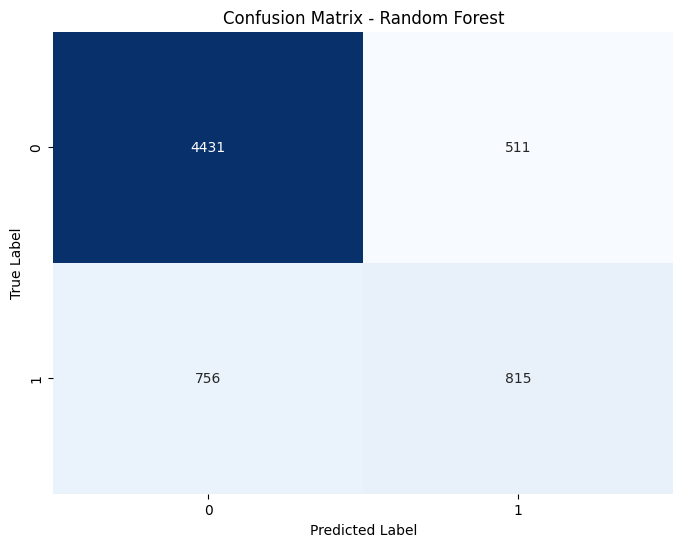

Accuracy: 0.8054659910947336
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4942
           1       0.61      0.52      0.56      1571

    accuracy                           0.81      6513
   macro avg       0.73      0.71      0.72      6513
weighted avg       0.80      0.81      0.80      6513

------------------------------------------------------------
Entrenando y evaluando el modelo: XGBoost


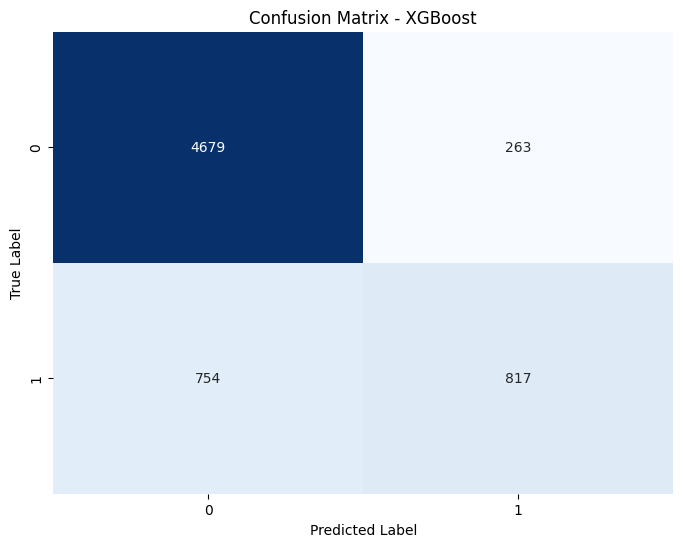

Accuracy: 0.8438507600184247
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      4942
           1       0.76      0.52      0.62      1571

    accuracy                           0.84      6513
   macro avg       0.81      0.73      0.76      6513
weighted avg       0.84      0.84      0.83      6513

------------------------------------------------------------
Entrenando y evaluando el modelo: KNN


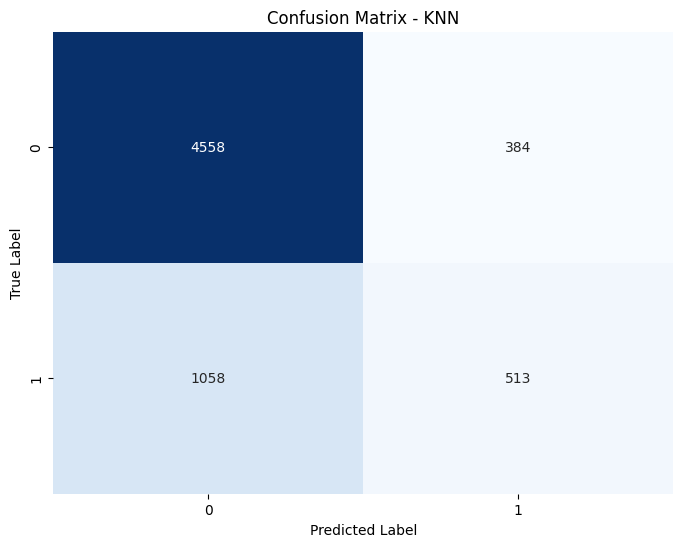

Accuracy: 0.7785966528481498
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      4942
           1       0.57      0.33      0.42      1571

    accuracy                           0.78      6513
   macro avg       0.69      0.62      0.64      6513
weighted avg       0.75      0.78      0.76      6513

------------------------------------------------------------
Entrenando y evaluando el modelo: SVM


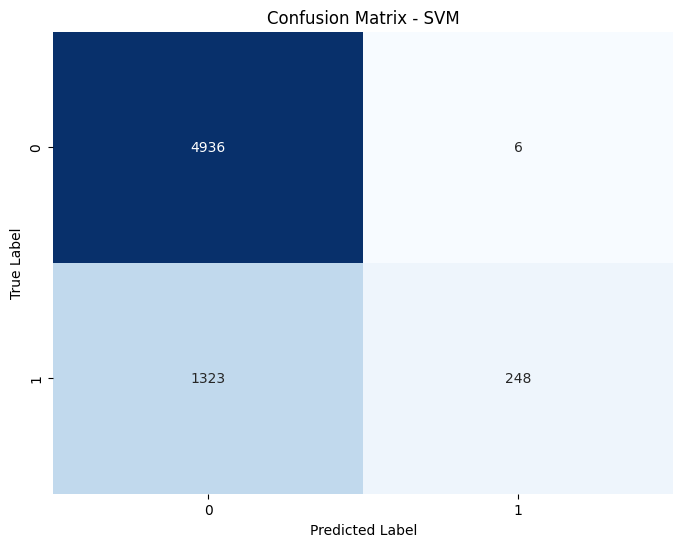

Accuracy: 0.7959465684016582
Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      4942
           1       0.98      0.16      0.27      1571

    accuracy                           0.80      6513
   macro avg       0.88      0.58      0.58      6513
weighted avg       0.83      0.80      0.73      6513

------------------------------------------------------------
Entrenando y evaluando el modelo: AdaBoost


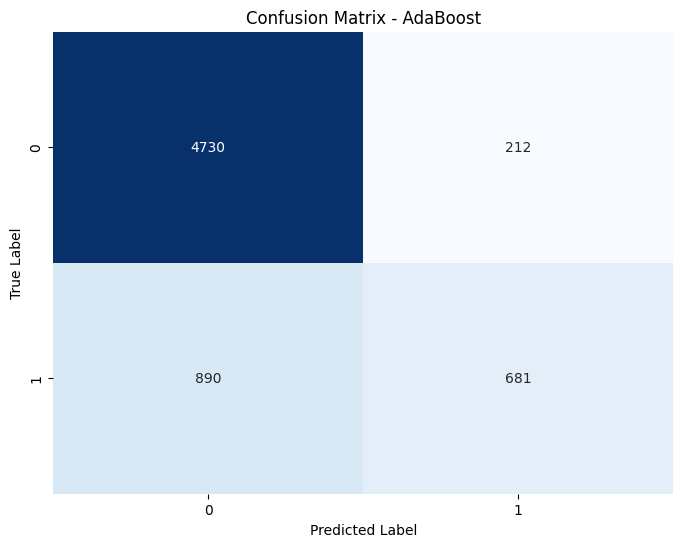

Accuracy: 0.8307999385843697
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      4942
           1       0.76      0.43      0.55      1571

    accuracy                           0.83      6513
   macro avg       0.80      0.70      0.72      6513
weighted avg       0.82      0.83      0.81      6513

------------------------------------------------------------
Entrenando y evaluando el modelo: Logistic Regression


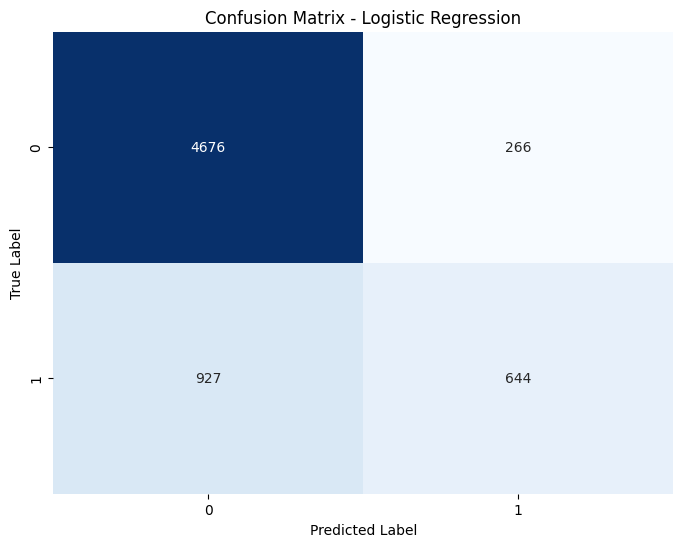

Accuracy: 0.8168278826961461
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      4942
           1       0.71      0.41      0.52      1571

    accuracy                           0.82      6513
   macro avg       0.77      0.68      0.70      6513
weighted avg       0.80      0.82      0.80      6513

------------------------------------------------------------
Entrenando y evaluando el modelo: Gradient Boosting


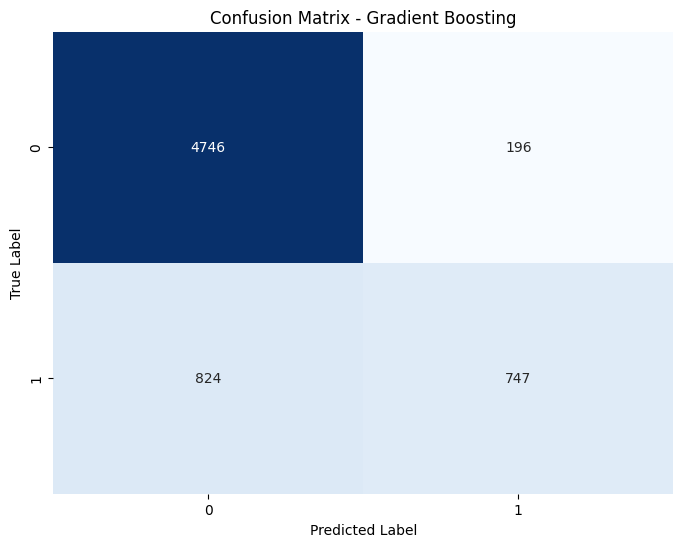

Accuracy: 0.8433901427913404
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      4942
           1       0.79      0.48      0.59      1571

    accuracy                           0.84      6513
   macro avg       0.82      0.72      0.75      6513
weighted avg       0.84      0.84      0.83      6513

------------------------------------------------------------
Entrenando y evaluando el modelo: Extra Trees


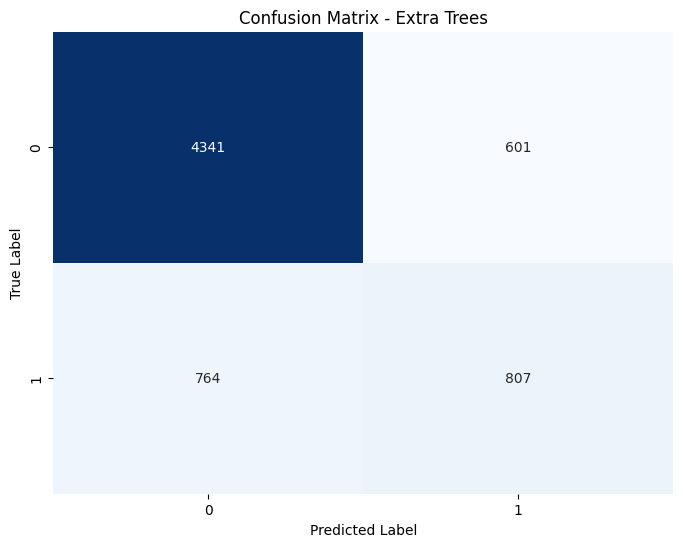

Accuracy: 0.7904191616766467
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      4942
           1       0.57      0.51      0.54      1571

    accuracy                           0.79      6513
   macro avg       0.71      0.70      0.70      6513
weighted avg       0.78      0.79      0.79      6513

------------------------------------------------------------
Entrenando y evaluando el modelo: Decision Tree


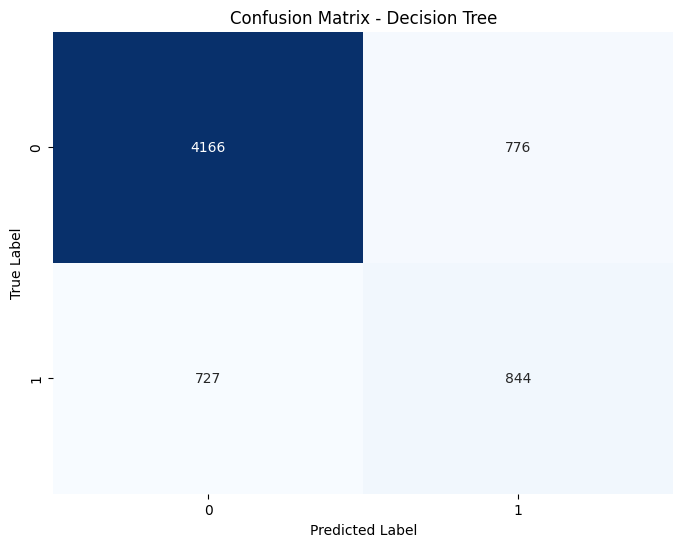

Accuracy: 0.7692307692307693
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      4942
           1       0.52      0.54      0.53      1571

    accuracy                           0.77      6513
   macro avg       0.69      0.69      0.69      6513
weighted avg       0.77      0.77      0.77      6513

------------------------------------------------------------
Entrenando y evaluando el modelo: LightGBM
[LightGBM] [Info] Number of positive: 6270, number of negative: 19778
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 591
[LightGBM] [Info] Number of data points in the train set: 26048, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240709 -> initscore=-1.148794
[LightGBM] [Info

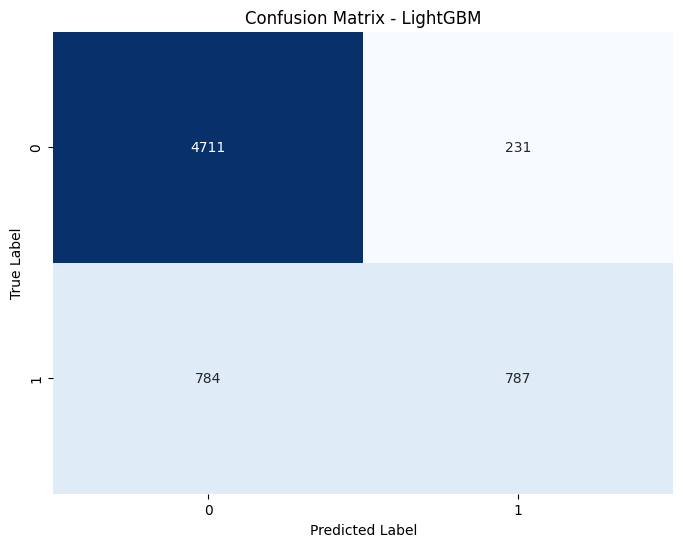

Accuracy: 0.8441578381698143
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      4942
           1       0.77      0.50      0.61      1571

    accuracy                           0.84      6513
   macro avg       0.82      0.73      0.76      6513
weighted avg       0.84      0.84      0.83      6513

------------------------------------------------------------
[LightGBM] [Info] Number of positive: 6270, number of negative: 19778
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 591
[LightGBM] [Info] Number of data points in the train set: 26048, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240709 -> initscore=-1.148794
[LightGBM] [Info] Start training from score -1.148794


,Model,Accuracy,Precision (0),Recall (0),F1-Score (0),Precision (1),Recall (1),F1-Score (1)
0,Random Forest,0.805312,0.854086,0.896601,0.874827,0.614340,0.518141,0.562155
1,XGBoost,0.843851,0.861218,0.946783,0.901976,0.756481,0.520051,0.616371
2,KNN,0.778597,0.811610,0.922299,0.863421,0.571906,0.326544,0.415721
3,SVM,0.795947,0.788624,0.998786,0.881350,0.976378,0.157861,0.271781
4,AdaBoost,0.830800,0.841637,0.957102,0.895664,0.762598,0.433482,0.552760
5,Logistic Regression,0.816828,0.834553,0.946176,0.886866,0.707692,0.409930,0.519146
6,Gradient Boosting,0.843390,0.852065,0.960340,0.902968,0.792153,0.475493,0.594272
7,Extra Trees,0.789651,0.850059,0.877580,0.863600,0.571226,0.513049,0.540577
8,Decision Tree,0.768617,0.849440,0.844800,0.847114,0.520025,0.528962,0.524456
9,LightGBM,0.844158,0.857325,0.953258,0.902750,0.773084,0.500955,0.607957


In [150]:
# Seleccionar solo las columnas que contienen datos numéricos
df_numerico = data_encoded.select_dtypes(include=['number'])

# Definir la variable objetivo y las variables predictoras
x = df_numerico.drop(columns=['income_binary']) 
y = df_numerico['income_binary']  

# Dividir el conjunto de datos en entrenamiento y prueba, reservando un 20% para prueba
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Definir en una matriz los modelos que vamos a comparar
models = {
    'Random Forest': RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier(eval_metric='mlogloss'),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(),
    'AdaBoost': AdaBoostClassifier(algorithm='SAMME'),
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Extra Trees': ExtraTreesClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'LightGBM': lgb.LGBMClassifier()
}

# Entrenar y evaluar los modelos
for name, model in models.items():
    print(f"Entrenando y evaluando el modelo: {name}")
    
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Hacer predicciones
    y_pred = model.predict(X_test)
    
    # Calcular la matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    
    # Visualizar la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()
    
    # Evaluar el modelo
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-" * 60)

# Inicializar un diccionario para almacenar los resultados y poder comparar los modelos
results = {
    'Model': [],
    'Accuracy': [],
    'Precision (0)': [],
    'Recall (0)': [],
    'F1-Score (0)': [],
    'Precision (1)': [],
    'Recall (1)': [],
    'F1-Score (1)': []
}

# Iterar sobre cada modelo
for name, model in models.items():
    
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Hacer predicciones
    y_pred = model.predict(X_test)
    
    # Evaluar el modelo
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Extraer métricas del reporte
    precision_0 = report['0']['precision']
    recall_0 = report['0']['recall']
    f1_0 = report['0']['f1-score']
    precision_1 = report['1']['precision']
    recall_1 = report['1']['recall']
    f1_1 = report['1']['f1-score']
    
    # Almacenar los resultados en el diccionario
    results['Model'].append(name)
    results['Accuracy'].append(accuracy)
    results['Precision (0)'].append(precision_0)
    results['Recall (0)'].append(recall_0)
    results['F1-Score (0)'].append(f1_0)
    results['Precision (1)'].append(precision_1)
    results['Recall (1)'].append(recall_1)
    results['F1-Score (1)'].append(f1_1)

# Crear un DataFrame a partir del diccionario de resultados
results_df = pd.DataFrame(results)

# Función para resaltar los valores máximos
def highlight_max(dataframe):
    styles = pd.DataFrame('', index=dataframe.index, columns=dataframe.columns)
    for col in dataframe.columns[1:]:  # Asegúrate de que esta línea termine con ':'
        max_val = dataframe[col].max()
        styles[col] = ['background-color: Green' if v == max_val else '' for v in dataframe[col]]
    return styles

# Aplicar el estilo
styled_df = results_df.style.apply(highlight_max, axis=None)

# Mostrar el DataFrame estilizado
styled_df


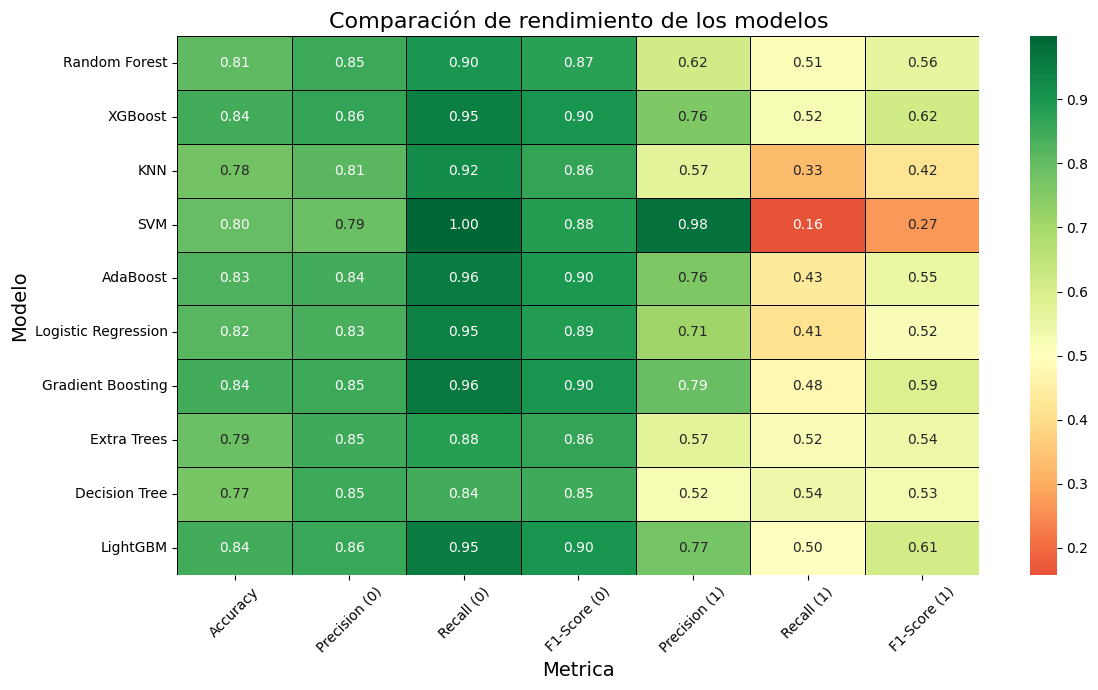

In [115]:
# Datos de rendimiento de los modelos
data = {
    'Model': [
        'Random Forest', 'XGBoost', 'KNN', 'SVM', 'AdaBoost', 
        'Logistic Regression', 'Gradient Boosting', 'Extra Trees', 
        'Decision Tree', 'LightGBM'
    ],
    'Accuracy': [
        0.805312, 0.843851, 0.778597, 0.795947, 0.830800, 
        0.816828, 0.843390, 0.790419, 0.769384, 0.844158
    ],
    'Precision (0)': [
        0.853405, 0.861218, 0.811610, 0.788624, 0.841637, 
        0.834553, 0.852065, 0.850893, 0.852026, 0.857325
    ],
    'Recall (0)': [
        0.897612, 0.946783, 0.922299, 0.998786, 0.957102, 
        0.946176, 0.960340, 0.877580, 0.842372, 0.953258
    ],
    'F1-Score (0)': [
        0.874951, 0.901976, 0.863421, 0.881350, 0.895664, 
        0.886866, 0.902968, 0.864030, 0.847171, 0.902750
    ],
    'Precision (1)': [
        0.615209, 0.756481, 0.571906, 0.976378, 0.762598, 
        0.707692, 0.792153, 0.572740, 0.521205, 0.773084
    ],
    'Recall (1)': [
        0.514959, 0.520051, 0.326544, 0.157861, 0.433482, 
        0.409930, 0.475493, 0.516232, 0.539784, 0.500955
    ],
    'F1-Score (1)': [
        0.560638, 0.616371, 0.415721, 0.271781, 0.552760, 
        0.519146, 0.594272, 0.543020, 0.530331, 0.607957
    ]
}

# Crear un DataFrame
df = pd.DataFrame(data).set_index('Model')

# Crear el heatmap
plt.figure(figsize=(12, 7))
heatmap = sns.heatmap(df, annot=True, cmap='RdYlGn', center=0.5, fmt='.2f', linewidths=.5, linecolor='black')

# Personalizar el gráfico
plt.title('Comparación de rendimiento de los modelos', fontsize=16)
plt.xlabel('Metrica', fontsize=14)
plt.ylabel('Modelo', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Mostrar el gráfico
plt.tight_layout()
plt.show()



In [116]:
# Cargar el dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", 
                "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", 
                "hours_per_week", "native_country", "income"]
data = pd.read_csv(url, names=column_names, na_values=" ?", skipinitialspace=True)

# Codificación One-Hot para variables categóricas
categorical_columns = ['workclass', 'education', 'marital_status', 'occupation', 
                       'relationship', 'race', 'sex', 'native_country']
data_encoded = pd.get_dummies(data, columns=categorical_columns)

# Codificación del objetivo binario
data_encoded['income_binary'] = data_encoded['income'].apply(lambda x: 1 if x == '>50K' else 0)
data_encoded = data_encoded.drop(['income'], axis=1)

# Verificar y limpiar datos faltantes
print(data_encoded.isnull().sum())
data_encoded = data_encoded.dropna()

# Dividir datos generales
X_general = data_encoded.drop(['income_binary'], axis=1)
y_general = data_encoded['income_binary']

X_train_general, X_test_general, y_train_general, y_test_general = train_test_split(X_general, y_general, test_size=0.2, random_state=42)

model_general = RandomForestClassifier()
model_general.fit(X_train_general, y_train_general)
y_pred_general = model_general.predict(X_test_general)

print("Modelo General")
print(confusion_matrix(y_test_general, y_pred_general, labels=[0, 1]))
print(classification_report(y_test_general, y_pred_general, zero_division=0, labels=[0, 1]))
print("-" * 60)

# Crear segmentos para horas trabajadas y años de educación
data_encoded['hours_per_week_segment'] = pd.cut(data_encoded['hours_per_week'], bins=[0, 20, 40, 60, 100], labels=['0-20', '21-40', '41-60', '61-100'])
data_encoded['education_num_segment'] = pd.cut(data_encoded['education_num'], bins=[0, 8, 12, 16, 20], labels=['0-8', '9-12', '13-16', '17-20'])

# Segmentación de datos
for hours_segment in data_encoded['hours_per_week_segment'].unique():
    for edu_segment in data_encoded['education_num_segment'].unique():
        segment_data = data_encoded[(data_encoded['hours_per_week_segment'] == hours_segment) & 
                                    (data_encoded['education_num_segment'] == edu_segment)]
        
        if segment_data.empty:
            print(f"Segmento vacío - Horas: {hours_segment}, Educación: {edu_segment}")
            continue
        
        X_segment = segment_data.drop(['income_binary', 'hours_per_week_segment', 'education_num_segment'], axis=1)
        y_segment = segment_data['income_binary']
        
        # Verificar si el segmento tiene solo una clase
        if len(y_segment.unique()) < 2:
            print(f"Segmento con una sola clase - Horas: {hours_segment}, Educación: {edu_segment}")
            continue
        
        X_train_segment, X_test_segment, y_train_segment, y_test_segment = train_test_split(X_segment, y_segment, test_size=0.2, random_state=42)
        
        model_segment = RandomForestClassifier()
        model_segment.fit(X_train_segment, y_train_segment)
        y_pred_segment = model_segment.predict(X_test_segment)
        
        print(f"Segmento - Horas: {hours_segment}, Educación: {edu_segment}")
        print(confusion_matrix(y_test_segment, y_pred_segment, labels=[0, 1]))
        print(classification_report(y_test_segment, y_pred_segment, zero_division=0, labels=[0, 1]))
        print("-" * 60)


age                               0
fnlwgt                            0
education_num                     0
capital_gain                      0
capital_loss                      0
                                 ..
native_country_Trinadad&Tobago    0
native_country_United-States      0
native_country_Vietnam            0
native_country_Yugoslavia         0
income_binary                     0
Length: 109, dtype: int64
Modelo General
[[4605  337]
 [ 574  997]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4942
           1       0.75      0.63      0.69      1571

    accuracy                           0.86      6513
   macro avg       0.82      0.78      0.80      6513
weighted avg       0.85      0.86      0.86      6513

------------------------------------------------------------
Segmento - Horas: 21-40, Educación: 13-16
[[381  93]
 [ 71 276]]
              precision    recall  f1-score   support

           0       0.84     

In [117]:
# Cargo el dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", 
                "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", 
                "hours_per_week", "native_country", "income"]
data = pd.read_csv(url, names=column_names, na_values=' ?', skipinitialspace=True)

# Preprocesamiento
data = pd.get_dummies(data)

# Verificar las columnas después de get_dummies
print("Columnas del DataFrame después de get_dummies:")
print(data.columns)

# Asegúrate de usar el nombre correcto de la columna objetivo después de get_dummies
X = data.drop([col for col in data.columns if col.startswith('income_')], axis=1)
y = data[[col for col in data.columns if col.startswith('income_')]].idxmax(axis=1).apply(lambda x: 1 if x == 'income_>50K' else 0)

# Dividir el dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Manejo del desbalanceo de clases
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Definir el modelo de LightGBM
lgb_model = lgb.LGBMClassifier()

# Definir el grid de parámetros para GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)

# Ajustar el modelo
grid_search.fit(X_train_resampled, y_train_resampled)

# Obtener los mejores parámetros
print("Mejores parámetros encontrados con GridSearchCV (LightGBM):")
print(grid_search.best_params_)

# Evaluar el modelo con los mejores parámetros
best_lgb_model = grid_search.best_estimator_
y_pred_lgb = best_lgb_model.predict(X_test)
print("Evaluación del modelo LightGBM con GridSearchCV:")
print(classification_report(y_test, y_pred_lgb))

# Definir el modelo XGBoost
xgb_model = xgb.XGBClassifier(scale_pos_weight=1) 

# Definir el grid de parámetros para RandomizedSearchCV
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(10, 30),
    'learning_rate': [0.01, 0.1, 0.2]
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='f1', n_jobs=-1)

# Ajustar el modelo
random_search.fit(X_train_resampled, y_train_resampled)

# Obtener los mejores parámetros
print("Mejores parámetros encontrados con RandomizedSearchCV (XGBoost):")
print(random_search.best_params_)

# Evaluar el modelo con los mejores parámetros
best_xgb_model = random_search.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)
print("Evaluación del modelo XGBoost con RandomizedSearchCV:")
print(classification_report(y_test, y_pred_xgb))

# Validación Cruzada

# Evaluar el modelo LightGBM con validación cruzada
cv_scores_lgb = cross_val_score(best_lgb_model, X, y, cv=5, scoring='f1')
print(f"Puntuaciones de validación cruzada para LightGBM: {cv_scores_lgb}")
print(f"Puntuación media: {cv_scores_lgb.mean()}")

# Evaluar el modelo XGBoost con validación cruzada
cv_scores_xgb = cross_val_score(best_xgb_model, X, y, cv=5, scoring='f1')
print(f"Puntuaciones de validación cruzada para XGBoost: {cv_scores_xgb}")
print(f"Puntuación media: {cv_scores_xgb.mean()}")

Columnas del DataFrame después de get_dummies:
Index(['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week', 'workclass_?', 'workclass_Federal-gov',
       'workclass_Local-gov', 'workclass_Never-worked',
       ...
       'native_country_Scotland', 'native_country_South',
       'native_country_Taiwan', 'native_country_Thailand',
       'native_country_Trinadad&Tobago', 'native_country_United-States',
       'native_country_Vietnam', 'native_country_Yugoslavia', 'income_<=50K',
       'income_>50K'],
      dtype='object', length=110)
[LightGBM] [Info] Number of positive: 19778, number of negative: 19778
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1123
[LightGBM] [Info] Number of data points in the train set: 39556, number of used features: 92

In [118]:
## Evaluación de Modelos XGBoost y LightGBM con Preprocesamiento y SMOTE: Validación Cruzada 

# Cargar los datos
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
                'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
                'hours_per_week', 'native_country', 'income']
data = pd.read_csv(url, header=None, names=column_names, na_values=' ?', skipinitialspace=True)

# Eliminar filas con valores faltantes
data.dropna(inplace=True)

# Convertir la columna 'income' en una variable binaria (0 y 1)
data['income'] = data['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

# Separar características y etiquetas
X = data.drop('income', axis=1)
y = data['income']

# Identificar columnas numéricas y categóricas
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

# Crear transformadores para columnas numéricas y categóricas
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')

# Crear un preprocesador que aplique las transformaciones adecuadas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

# Crear pipelines para XGBoost y LightGBM
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
])

lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LGBMClassifier(random_state=42))
])

# Configurar validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar los modelos usando validación cruzada
xgb_scores = cross_val_score(xgb_pipeline, X, y, cv=cv, scoring='accuracy')
lgbm_scores = cross_val_score(lgbm_pipeline, X, y, cv=cv, scoring='accuracy')

# Imprimir los resultados
print("Resultados de la validación cruzada para XGBoost:")
print(f"Precisión media: {xgb_scores.mean():.4f}")
print(f"Desviación estándar: {xgb_scores.std():.4f}")

print("\nResultados de la validación cruzada para LightGBM:")
print(f"Precisión media: {lgbm_scores.mean():.4f}")
print(f"Desviación estándar: {lgbm_scores.std():.4f}")



[LightGBM] [Info] Number of positive: 19776, number of negative: 19776
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10337
[LightGBM] [Info] Number of data points in the train set: 39552, number of used features: 97
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 19776, number of negative: 19776
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 39552, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0

Reporte de clasificación para XGBoost:

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      7417
           1       0.74      0.70      0.72      2352

    accuracy                           0.87      9769
   macro avg       0.82      0.81      0.82      9769
weighted avg       0.87      0.87      0.87      9769

----------------------------------------
[LightGBM] [Info] Number of positive: 17303, number of negative: 17303
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1182
[LightGBM] [Info] Number of data points in the train set: 34606, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Reporte de clasificación para LightGBM:

              precision    recall  f1-score   su

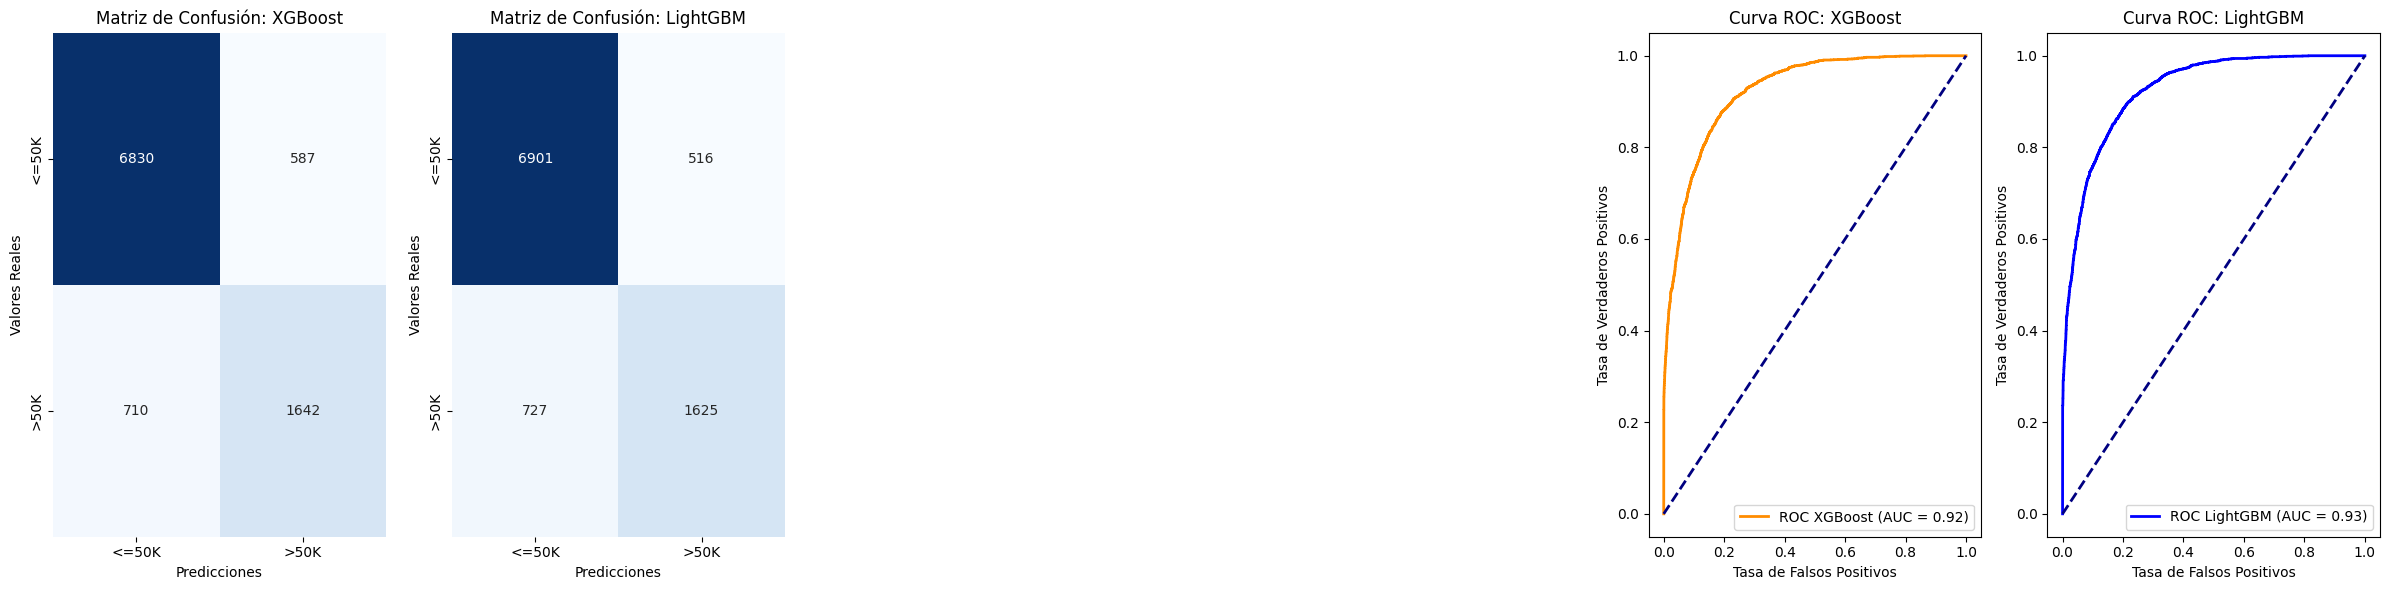

In [119]:
# Matriz de confusión y Curva ROC
# Cargar los datos
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
                'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
                'hours_per_week', 'native_country', 'income']
data = pd.read_csv(url, header=None, names=column_names, na_values=' ?', skipinitialspace=True)

# Eliminar filas con valores faltantes
data.dropna(inplace=True)

# Convertir la columna 'income' en una variable binaria (0 y 1), eliminando espacios extra
data['income'] = data['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

# Separar características y etiquetas
X = data.drop('income', axis=1)
y = data['income']

# Convertir las variables categóricas en variables dummies (one-hot encoding)
X = pd.get_dummies(X, drop_first=True)

# Dividir los datos en conjunto de entrenamiento y prueba, usando estratificación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Aplicar SMOTE para balancear la clase minoritaria en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Estandarizar los datos
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Definir el modelo XGBoost
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')

# Entrenar el modelo XGBoost
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predecir en el conjunto de prueba con XGBoost
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Calcular las métricas para XGBoost
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)

# Imprimir el reporte de clasificación para XGBoost
print(f"Reporte de clasificación para XGBoost:\n")
print(classification_report(y_test, y_pred_xgb))
print("-" * 40)

# Crear la matriz de confusión para XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Definir el modelo LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42)

# Entrenar el modelo LightGBM
lgb_model.fit(X_train_resampled, y_train_resampled)

# Predecir en el conjunto de prueba con LightGBM
y_pred_lgb = lgb_model.predict(X_test_scaled)
y_proba_lgb = lgb_model.predict_proba(X_test_scaled)[:, 1]

# Calcular las métricas para LightGBM
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
precision_lgb = precision_score(y_test, y_pred_lgb)
recall_lgb = recall_score(y_test, y_pred_lgb)
f1_lgb = f1_score(y_test, y_pred_lgb)
roc_auc_lgb = roc_auc_score(y_test, y_proba_lgb)

# Imprimir el reporte de clasificación para LightGBM
print(f"Reporte de clasificación para LightGBM:\n")
print(classification_report(y_test, y_pred_lgb))
print("-" * 40)

# Graficar las matrices de confusión, la comparación de valores reales y predicciones y la curva ROC para ambos modelos
plt.figure(figsize=(24, 6))

# Matriz de confusión para XGBoost
plt.subplot(1, 6, 1)
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["<=50K", ">50K"], yticklabels=["<=50K", ">50K"])
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión: XGBoost")

# Matriz de confusión para LightGBM
plt.subplot(1, 6, 2)
sns.heatmap(cm_lgb, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["<=50K", ">50K"], yticklabels=["<=50K", ">50K"])
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión: LightGBM")

# Curva ROC para XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.subplot(1, 6, 5)
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'ROC XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC: XGBoost')
plt.legend(loc="lower right")

# Curva ROC para LightGBM
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_proba_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)

plt.subplot(1, 6, 6)
plt.plot(fpr_lgb, tpr_lgb, color='blue', lw=2, label=f'ROC LightGBM (AUC = {roc_auc_lgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC: LightGBM')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()


[LightGBM] [Info] Number of positive: 17303, number of negative: 17303
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1182
[LightGBM] [Info] Number of data points in the train set: 34606, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


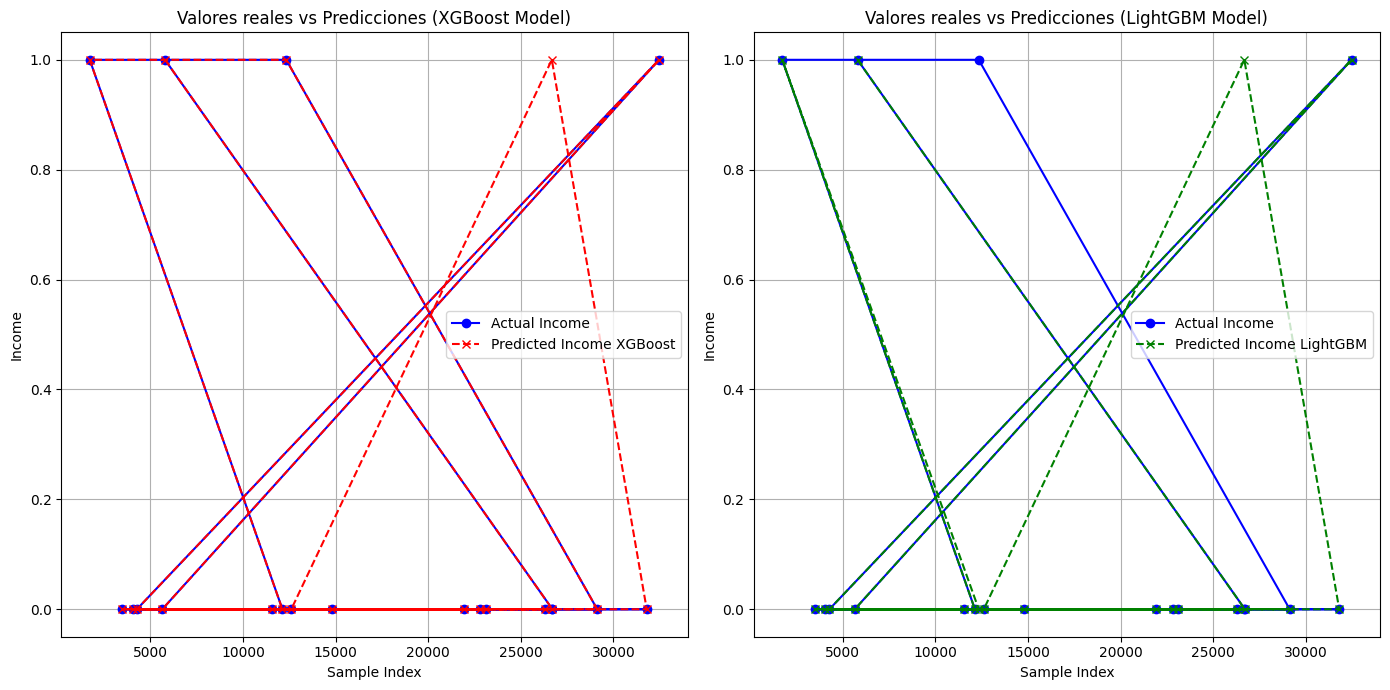

       Actual Income  Predicted Income XGBoost  Predicted Income LightGBM
5794               1                         1                          1
26705              0                         0                          0
3474               0                         0                          0
31797              0                         0                          0
26674              0                         1                          1
12609              0                         0                          0
23116              0                         0                          0
4048               0                         0                          0
14792              0                         0                          0
11543              0                         0                          0
21909              0                         0                          0
5644               0                         0                          0
32462              1                  

In [120]:
# Valores reales vs Predicciones
# Cargar los datos
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
                'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
                'hours_per_week', 'native_country', 'income']
data = pd.read_csv(url, header=None, names=column_names, na_values=' ?', skipinitialspace=True)

# Eliminar filas con valores faltantes
data.dropna(inplace=True)

# Convertir la columna 'income' en una variable binaria (0 y 1)
data['income'] = data['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

# Separar características y etiquetas
X = data.drop('income', axis=1)
y = data['income']

# Convertir las variables categóricas en variables dummies (one-hot encoding)
X = pd.get_dummies(X, drop_first=True)

# Dividir los datos en conjunto de entrenamiento y prueba, usando estratificación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Aplicar SMOTE para balancear la clase minoritaria en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Estandarizar los datos
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Definir el modelo XGBoost
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')

# Entrenar el modelo
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predecir en el conjunto de prueba
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Definir el modelo LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42)

# Entrenar el modelo
lgb_model.fit(X_train_resampled, y_train_resampled)

# Predecir en el conjunto de prueba
y_pred_lgb = lgb_model.predict(X_test_scaled)

# Crear un DataFrame para comparar los valores predichos con los reales para ambos modelos
comparison_df = pd.DataFrame({
    'Actual Income': y_test,
    'Predicted Income XGBoost': y_pred_xgb,
    'Predicted Income LightGBM': y_pred_lgb
})

# Visualización de las primeras 20 comparaciones
comparison_df_sample = comparison_df.head(20)

# Plot de las comparaciones
plt.figure(figsize=(14, 7))

# Plot para XGBoost
plt.subplot(1, 2, 1)
plt.plot(comparison_df_sample.index, comparison_df_sample['Actual Income'], label='Actual Income', marker='o', linestyle='-', color='b')
plt.plot(comparison_df_sample.index, comparison_df_sample['Predicted Income XGBoost'], label='Predicted Income XGBoost', marker='x', linestyle='--', color='r')
plt.title('Valores reales vs Predicciones (XGBoost Model)')
plt.xlabel('Sample Index')
plt.ylabel('Income')
plt.legend()
plt.grid(True)

# Plot para LightGBM
plt.subplot(1, 2, 2)
plt.plot(comparison_df_sample.index, comparison_df_sample['Actual Income'], label='Actual Income', marker='o', linestyle='-', color='b')
plt.plot(comparison_df_sample.index, comparison_df_sample['Predicted Income LightGBM'], label='Predicted Income LightGBM', marker='x', linestyle='--', color='g')
plt.title('Valores reales vs Predicciones (LightGBM Model)')
plt.xlabel('Sample Index')
plt.ylabel('Income')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Mostrar la muestra de datos para referencia
print(comparison_df_sample)



In [121]:
# Calculo mejores parámetros

# Cargar los datos
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
                'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
                'hours_per_week', 'native_country', 'income']
data = pd.read_csv(url, header=None, names=column_names, na_values=' ?', skipinitialspace=True)

# Eliminar filas con valores faltantes
data.dropna(inplace=True)

# Convertir la columna 'income' en una variable binaria (0 y 1)
data['income'] = data['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

# Separar características y etiquetas
x = data.drop('income', axis=1)
y = data['income']

# Convertir variables categóricas a numéricas (ejemplo simple)
x = pd.get_dummies(x, drop_first=True)

# Aquí se usa un ejemplo simple de división de datos
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# LightGBM
lgb_param_grid = {
    'num_leaves': [31, 127],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [20, 40]
}

lgb_grid = GridSearchCV(LGBMClassifier(), lgb_param_grid, cv=3, scoring='f1')
lgb_grid.fit(x_train, y_train)
print("Best LightGBM parameters:", lgb_grid.best_params_)

# XGBoost
xgb_param_grid = {
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 100]
}

xgb_grid = GridSearchCV(XGBClassifier(eval_metric='mlogloss'), xgb_param_grid, cv=3, scoring='f1')
xgb_grid.fit(x_train, y_train)
print("Best XGBoost parameters:", xgb_grid.best_params_)



[LightGBM] [Info] Number of positive: 4180, number of negative: 13185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 718
[LightGBM] [Info] Number of data points in the train set: 17365, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240714 -> initscore=-1.148769
[LightGBM] [Info] Start training from score -1.148769
[LightGBM] [Info] Number of positive: 4180, number of negative: 13185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 707
[LightGBM] [Info] Number of data points in the train set: 17365, number of used features: 77
[LightGBM] [Info] [bin

In [122]:
# Cargo los mejores parámetros
best_lgb_params = lgb_grid.best_params_
best_xgb_params = xgb_grid.best_params_

# Configurar el modelo con los mejores parámetros
lgb_best_model = lgb.LGBMClassifier(**best_lgb_params)
xgb_best_model = xgb.XGBClassifier(**best_xgb_params, eval_metric='mlogloss')

# Entrenar y evaluar los modelos
lgb_best_model.fit(x_train, y_train)
xgb_best_model.fit(x_train, y_train)

lgb_best_pred = lgb_best_model.predict(x_test)
xgb_best_pred = xgb_best_model.predict(x_test)

lgb_best_f1 = f1_score(y_test, lgb_best_pred, pos_label=1)
xgb_best_f1 = f1_score(y_test, xgb_best_pred, pos_label=1)

print("Best LightGBM F1-Score:", lgb_best_f1)
print("Best XGBoost F1-Score:", xgb_best_f1)

# Imprimir el reporte de clasificación para LightGBM
print("\nClassification Report for LightGBM:")
print(classification_report(y_test, lgb_best_pred))

# Imprimir el reporte de clasificación para XGBoost
print("\nClassification Report for XGBoost:")
print(classification_report(y_test, xgb_best_pred))



[LightGBM] [Info] Number of positive: 6270, number of negative: 19778
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 747
[LightGBM] [Info] Number of data points in the train set: 26048, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240709 -> initscore=-1.148794
[LightGBM] [Info] Start training from score -1.148794
Best LightGBM F1-Score: 0.7163444639718805
Best XGBoost F1-Score: 0.730915371329879

Classification Report for LightGBM:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4942
           1       0.80      0.65      0.72      1571

    accuracy                           0.88      6513
   macro avg       0.85      0.80      0.82      6513
weighted avg       0.87      0.88      0.87      65

                              Feature  Importance
30  marital_status_Married-civ-spouse    0.487427
2                       education_num    0.048387
3                        capital_gain    0.043128
42           occupation_Other-service    0.032812
51             relationship_Own-child    0.028099
..                                ...         ...
92            native_country_Scotland    0.000000
95            native_country_Thailand    0.000000
94              native_country_Taiwan    0.000000
96     native_country_Trinadad&Tobago    0.000000
99          native_country_Yugoslavia    0.000000

[100 rows x 2 columns]
                           Feature  Importance
0                              age         179
4                     capital_loss         162
3                     capital_gain         159
2                    education_num         118
5                   hours_per_week         116
..                             ...         ...
93            native_country_South           0


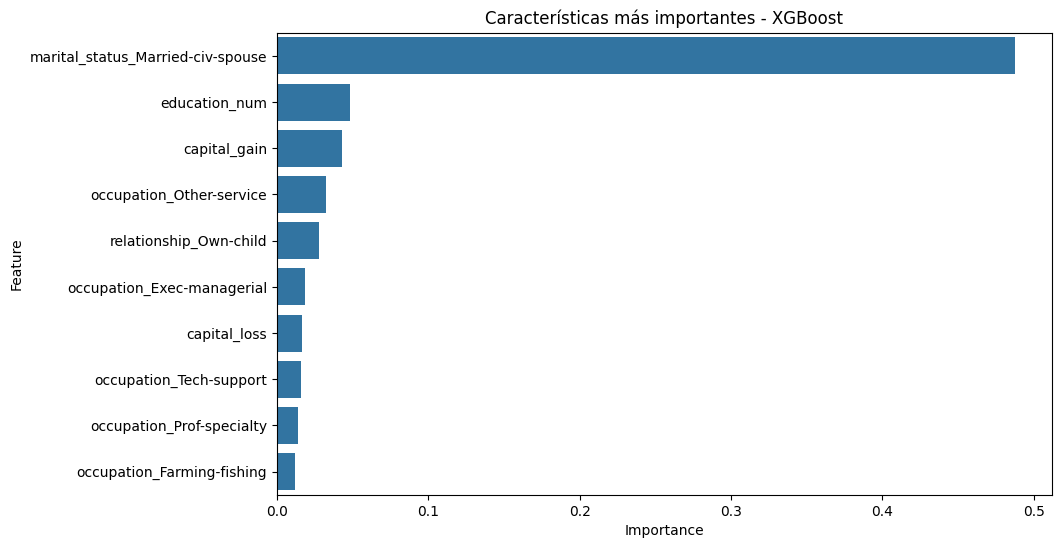

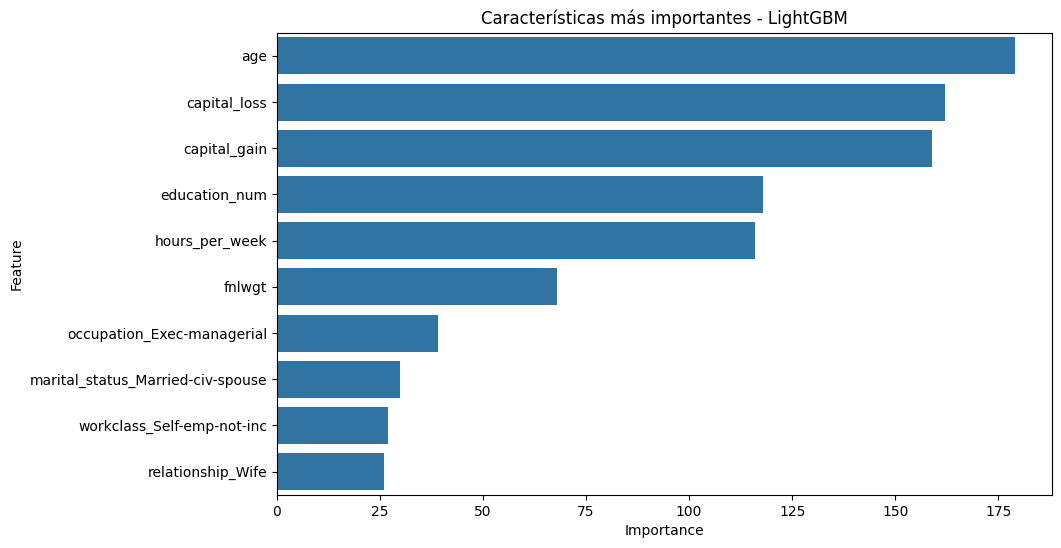

In [141]:
# Importancia de las columnas que definimos en las preguntas de Investigación

importances_xgb = xgb_best_model.feature_importances_
feature_names = x_train.columns

# Crear un DataFrame de importancias
importance_df_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': importances_xgb})
importance_df_xgb = importance_df_xgb.sort_values(by='Importance', ascending=False)

# Imprimir las características más importantes
print(importance_df_xgb)

importances_lgb = lgb_best_model.feature_importances_
importance_df_lgb = pd.DataFrame({'Feature': feature_names, 'Importance': importances_lgb})
importance_df_lgb = importance_df_lgb.sort_values(by='Importance', ascending=False)

# Imprimir las características más importantes
print(importance_df_lgb)

# Visualizar las 10 características más importantes para XGBoost
top_10_xgb = importance_df_xgb.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_xgb)
plt.title('Características más importantes - XGBoost')
plt.show()

# Visualizar las 10 características más importantes para LightGBM
top_10_lgb = importance_df_lgb.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_lgb)
plt.title('Características más importantes - LightGBM')
plt.show()

In [144]:
# Imprimir todas las características de XGBoost
print("Características en XGBoost:")
print(importance_df_xgb.to_string(index=False))

# Imprimir todas las características de LightGBM
print("Características en LightGBM:")
print(importance_df_lgb.to_string(index=False))

# Filtrar importancia del sexo en LightGBM
sex_m_importance_lgb = importance_df_lgb[importance_df_lgb['Feature'] == 'sex_Male']
print("Importancia del Sexo en LightGBM:")
print(sex_m_importance_lgb)

Características en XGBoost:
                                  Feature  Importance
        marital_status_Married-civ-spouse    0.487427
                            education_num    0.048387
                             capital_gain    0.043128
                 occupation_Other-service    0.032812
                   relationship_Own-child    0.028099
               occupation_Exec-managerial    0.018480
                             capital_loss    0.016977
                  occupation_Tech-support    0.015706
                occupation_Prof-specialty    0.013804
               occupation_Farming-fishing    0.012137
                                      age    0.011463
                           hours_per_week    0.010813
                        relationship_Wife    0.010353
                    workclass_Federal-gov    0.009887
                         occupation_Sales    0.009649
                                 sex_Male    0.009577
             occupation_Machine-op-inspct    0.009401
